In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

## IMPORTS
    
import numpy as np
import glob, datetime, os, sys
import random
import csv

from astropy.io import fits
from astropy.stats import sigma_clip, SigmaClip, mad_std, sigma_clipped_stats

from tqdm.auto import tqdm
from stdpipe.plots import imshow

import matplotlib.pyplot as plt
plt.rc('image', interpolation='nearest', origin='lower', cmap='hot')
plt.rcParams['figure.facecolor'] = 'white'
rcParams = plt.rcParams.copy()

from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

from scipy.stats import norm, anderson, kstest
from scipy.signal import find_peaks
from scipy.ndimage import median_filter  # if needed for other steps


# AUXILARY FUNCTIONS

def crop_overscans(image):
    if image.shape == (1152,1152):
#         image = 1.0*image - rmean(image[-14:-4, 800:])
        image = image[:-400,400:]
        
    elif image.shape == (1509, 2252): # G2 new, very crude estimation
#         image = 1.0*image - rmean(image[5:25, 100:-100])
        image = image[35:, 50:-100]
        
    elif image.shape == (754, 1126):
#         image = 1.0*image - rmean(image[3:12, 50:-50])
        image = image[18:, 25:-50]       
    
    elif image.shape == (1031, 1551): # G2 old
#         image = 1.0*image - rmean(image[1:2, 50:-50])
        image = image[4:-4,10:-10]    
        
    elif image.shape == (515, 775):
#         image = 1.0*image - rmean(image[0:1, 25:-25])
        image = image[2:-2,5:-5]    
        
    elif image.shape == (4096, 4160):
#         image = 1.0*image - rmean(image[:, -64:])
        image = image[:, :-64]
        
    return image


def median_stacking(images, sigma=3):
    """
    Perform 3-sigma clipped median stacking on a list of images.
    """

    # Perform sigma clipping
    clipped_data = sigma_clip(images, sigma=sigma, axis=0)
    
    # Calculate the median, ignoring NaNs introduced by sigma clipping
    median_image = np.nanmedian(clipped_data, axis=0)
        
    return median_image

# OTHER AUXILARY FUNCTIONS

def highlight_pixels(pixel_coords, name, image_size = (4096,4096)):
    """
    Function to create an image where specific pixels are highlighted in red.

    Parameters:
    image_size (tuple): Size of the image as (height, width).
    pixel_coords (list of tuples): List of pixel coordinates to highlight (x, y).

    Returns:
    None: Displays the image with highlighted pixels.
    """
    
    # Create a white image (3 channels for RGB)
    image = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 255  # White background
    
    # Paint the specified pixels red
    for (x, y) in pixel_coords:
        image[x, y] = [255, 0, 0]  # Red color
  
    plt.figure(figsize =(12,12))
    # Plot the image
    plt.imshow(image)
    plt.title(f'{name} Highlighted Pixels')
    plt.axis('off')  # Hide axis
    plt.show()

def plot_with_histogram(data, title, color ="blue",ylabel = "ADU"):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(12, 4))

    # Calculate the median value
    median_value = np.median(data)

    # Main scatter plot
    ax[0].plot(range(1, len(data) + 1), data, marker='.', linestyle='None', color=color)
    ax[0].set_xlabel('Image No')
    ax[0].set_ylabel(ylabel)
    ax[0].grid(True)
    ax[0].set_title(title)
    
    # Add horizontal line for the median on the scatter plot
    ax[0].axhline(y=median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')
    ax[0].legend()

        # Robust bin calculation (number of bins is max - min + 1)
    bin_range = int(np.max(data) - np.min(data)) + 1
    bins = np.linspace(np.min(data), np.max(data), bin_range)

    # Histogram on the side
    ax[1].hist(data, bins=bins, orientation='horizontal', color=color, alpha=0.7, edgecolor='black')
    ax[1].set_ylabel(ylabel)
    ax[1].set_xlabel('Frequency')

    # Add vertical line for the median on the histogram
    ax[1].axhline(y=median_value, color='red', linestyle='--')

    # Adjust layout
    plt.tight_layout()
    plt.show()


def time_hist_with_gmm(data, gmm, title):
    # Prepare figure with scatter plot and histogram
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(12, 6), sharey=True)
    
    ax[0].scatter(range(len(data)), data, color="blue", alpha=0.7)    
    ax[0].set_xlabel('Image No')
    ax[0].set_ylabel("ADU")
    ax[0].grid(True)
    ax[0].set_title(title)
    #ax[0].legend()
    
    # Calculate statistics and add a horizontal line for the overall median
    median_value = np.median(data)
    ax[0].axhline(y=median_value, color='red', linestyle='--', label=f'Median: {median_value:.2f}')

    # Robust bin calculation: number of bins = max - min + 1
    bin_range = int(np.max(data) - np.min(data)) + 1
    bins = np.linspace(np.min(data), np.max(data), bin_range)

    # Histogram on the side
    hist_data, bins, _ = ax[1].hist(data, bins=bins, orientation='horizontal', 
                                      color='blue', alpha=0.7, edgecolor='black')
    ax[1].set_ylabel("ADU")
    ax[1].set_xlabel('Frequency')
    ax[1].axhline(y=median_value, color='red', linestyle='--')  # Vertical line for median

    # Extract GMM parameters
    gmm_means = gmm.means_.flatten()
    # Handle tied covariances: for 1D tied, covariances_ is a 1x1 array.
    if gmm.covariance_type == 'tied':
        tied_std = np.sqrt(gmm.covariances_[0, 0])
        gmm_stds = np.full_like(gmm_means, tied_std)
    else:
        gmm_stds = np.sqrt(gmm.covariances_.flatten())
    gmm_weights = gmm.weights_

    # Define a helper to compute a Gaussian curve
    def gaussian(x, mean, std, weight, scale):
        return (weight * scale * np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi)))

    # Determine a scale factor for plotting (you may adjust as needed)
    bin_width = bins[1] - bins[0]
    # Option 1: scale based on histogram max and bin width
    # scale_factor = np.max(hist_data) * bin_width  
    # Option 2: use the number of data points
    scale_factor = len(data)

    # Plot the GMM components on the histogram
    if len(gmm_means) == 3:
        # If more than one component, assume ordering: Lower, Middle, Upper
        for i, label in enumerate(['Lower', 'Middle', 'Upper']):
            mean = gmm_means[i]
            std = gmm_stds[i]
            weight = gmm_weights[i]
            gauss = gaussian(bins, mean, std, weight, scale_factor)
            lab = f'{label} Gaussian: µ={mean:.2f}, σ={std:.2f}'
            print(lab)
            ax[1].plot(gauss, bins, linestyle='-', label=lab, linewidth=2)
    elif len(gmm_means) == 2:
        # If more than one component, assume ordering: Lower, Middle, Upper
        for i, label in enumerate(['Lower', 'Upper']):
            mean = gmm_means[i]
            std = gmm_stds[i]
            weight = gmm_weights[i]
            gauss = gaussian(bins, mean, std, weight, scale_factor)
            lab = f'{label} Gaussian: µ={mean:.2f}, σ={std:.2f}'
            print(lab)
            ax[1].plot(gauss, bins, linestyle='-', label=lab, linewidth=2)
    else:
        mean = gmm_means[0]
        std = gmm_stds[0]
        weight = gmm_weights[0]
        gauss = gaussian(bins, mean, std, weight, scale_factor)
        lab = f'1 Gaussian: µ={mean:.2f}, σ={std:.2f}'
        print(lab)
        ax[1].plot(gauss, bins, linestyle='-', label=lab, linewidth=2)

    # Display the legend and adjust the layout
    ax[1].legend()
    plt.tight_layout()
    plt.show()




## Read The Images and Preprocess

In [2]:
base = [
    #'/home/ozdogru/c4/img_c5/dark_1/20241220_162650/',
    #'/home/ozdogru/c4/img_c5/dark_0.1/20241220_210124/',
    #'/home/ozdogru/c4/img_c5/dark_10/20241220_172256/',
    #'/home/ozdogru/c4/img_c5/dark_5/20241218_223954/',
    #'/home/ozdogru/c4/img_c5/dark_temp_-10_1/20241220_211941/',
    '/home/ozdogru/c4/img_c5/20241223_034059/'
]

RON = 3.5
im_size = 4096
division = 16
multip = int(im_size/division)

all_images_list = []

for folder_idx, folder in enumerate(base):
    files = glob.glob(os.path.join(folder, '*.fits'))

    for i in range(1, 2):  # quadrant loops
        for j in range(1, 2):
            images_blocks = []

            # 1) Read & crop each image
            for filename in tqdm(files[:], desc=f"Processing division ({i}, {j}) images in {folder}"):
                with fits.open(filename, memmap=True) as hdul:
                    quadrant = hdul[1].section[(i * multip):((i + 1) * multip), (j * multip):((j + 1) * multip)]
                    #quadrant = hdul[1].section[500:600, 500:600]
                    hdul.close()
                

                images_blocks.append(quadrant)

            # Convert to 3D array: shape (n_frames, h, w)
            images = np.array(images_blocks, dtype=np.float64)
            n_frames, h, w = images.shape

            # 2) Median & std per pixel
            pix_median = np.median(images, axis=0)
            pix_std    = np.std(images, axis=0, ddof=1)

            
            # 3) Compute global threshold: ±10σ using the median of pix_std
            #    (You might consider doing per-pixel thresholds, but here we're using a single value.)
            global_upper = pix_median + 10*pix_std
            global_lower = pix_median - 10*pix_std

            # 4) Clip outliers and subtract the median
            for frame_idx in range(n_frames):
                frame = images[frame_idx]
                high_mask = (frame > global_upper)
                low_mask  = (frame < global_lower)
                frame[high_mask] = pix_median[high_mask]
                frame[low_mask]  = pix_median[low_mask]
                # Subtract median
                images[frame_idx] = frame - pix_median
            
            
            # Now we have a block of processed images (n_frames, h, w)
            # 5) Append to all_images_list
            all_images_list.append(images)

# 6) At the end, concatenate all blocks along axis=0
images = np.concatenate(all_images_list, axis=0)
print(f"all_images shape = {images.shape}")




Processing division (1, 1) images in /home/ozdogru/c4/img_c5/20241223_034059/:   0%|          | 0/10000 [00:00…

all_images shape = (10000, 256, 256)


## Dithered AD calculation

  0%|          | 0/256 [00:00<?, ?it/s]

[0.576 0.656 0.787 0.918 1.092]
[CritVal 0] AD < 0.576: 39790/65536  (60.71%)
[CritVal 1] AD < 0.656: 43492/65536  (66.36%)
[CritVal 2] AD < 0.787: 47206/65536  (72.03%)
[CritVal 3] AD < 0.918: 49363/65536  (75.32%)
[CritVal 4] AD < 1.092: 50977/65536  (77.78%)


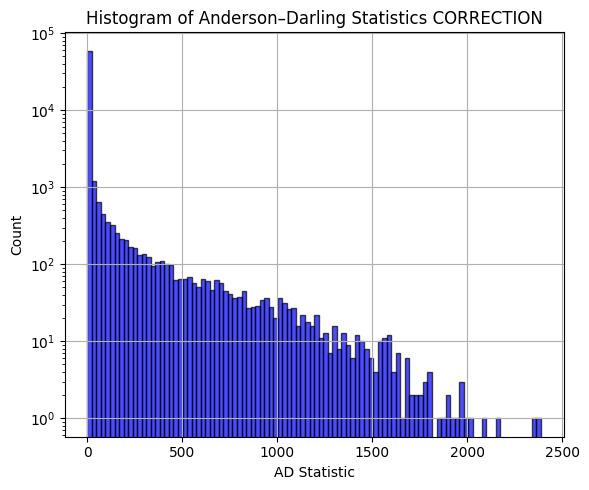

In [3]:

n_frames, h, w = images.shape

# 1) Prepare arrays to store results for each pixel
#    - ad_stat_map: 2D array for the main Anderson–Darling statistic
#    - You can also store critical values or significance levels if desired
ad_stat_map = np.zeros((h, w), dtype=float)
ad_crit_map = np.zeros((h, w), dtype=float)

# 2) Loop over each pixel => compute A–D test
for yy in tqdm(range(h)):
    for xx in range(w):
        # pixel_values is shape (n_frames,) i.e. across all frames
        pixel_values = images[:, yy, xx]

        pixel_values = pixel_values + np.random.uniform(-0.5, 0.5, size=pixel_values.shape)
        #pixel_values = pixel_values + np.random.normal(loc = 0, scale = 0.5, size=pixel_values.shape )

        # (a) Run A–D for normal distribution
        ad_res = anderson(pixel_values, dist='norm')

        # (b) Store the main statistic
        ad_stat_map[yy, xx] = ad_res.statistic
        ad_critvals = ad_res.critical_values
        ad_siglevs = ad_res.significance_level
        idx=5
        for i, crit in enumerate(ad_critvals): 
            if ad_stat_map[yy,xx] < crit:
                ad_crit_map[yy,xx]=i
                break
         
print(ad_critvals)

for i, ad_th in enumerate(ad_critvals):
    mask = (ad_stat_map < ad_th)
    count_below = np.count_nonzero(mask)
    percentage_below = 100.0 * count_below / (h * w)
    print(f"[CritVal {i}] AD < {ad_th:.3f}: {count_below}/{h*w}  ({percentage_below:.2f}%)")

# 1) Histogram of AD statistic (ad_stat_map)
plt.figure(figsize=(6,5))
plt.hist(ad_stat_map.ravel(), bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Anderson–Darling Statistics CORRECTION")
plt.xlabel("AD Statistic")
plt.ylabel("Count")
plt.yscale('log')
#plt.xlim(0,5)
plt.grid(True)
plt.tight_layout()
plt.show()




## Fitting and Reiteration

In [4]:
# ================== Single, Double, Triple, Penta Gaussians for curve-fit ==================
from scipy.optimize import  Bounds

def gaussian_1(x, w1, m1, s1):
    """
    Single Gaussian function with weight.
    The function returns:
        w1 * (1/(s1 * sqrt(2*pi))) * exp( -0.5 * ((x-m1)/s1)**2 )
    so that the integrated area equals w1.
    """
    dx = np.mean(np.diff(x)) if len(x) > 1 else 1.0

    norm = 1.0 / (s1 * np.sqrt(2 * np.pi)) * dx
    return w1 *norm * np.exp(-0.5 * ((x - m1) / s1)**2)

def gaussian2_pos(x, 
                  w1, m,
                  mean_shift, s):
    """
    Two Gaussian components with a positive mean shift.
    Each Gaussian is normalized to have area 1 so that the weights w1 and w2 
    represent their respective fractional contributions.
    """
    m2 = m + mean_shift
    w2 = 1.0 - w1
 
    dx = np.mean(np.diff(x)) if len(x) > 1 else 1.0
    norm = 1.0 / (s * np.sqrt(2 * np.pi))
    g1 = w1 * norm * np.exp(-0.5 * ((x - m) / s)**2) * dx
    g2 = w2 * norm * np.exp(-0.5 * ((x - m2) / s)**2) * dx
    return g1 + g2

def gaussian2_neg(x, 
                  w1,
                  m, mean_shift, s):
    """
    Two Gaussian components with a negative mean shift.
    Each Gaussian is normalized to have area 1 so that the weights w1 and w2 
    represent their respective contributions.
    """
    m2 = m - mean_shift
    
    w2 = 1.0 - w1
 
    dx = np.mean(np.diff(x)) if len(x) > 1 else 1.0
    norm = 1.0 / (s * np.sqrt(2 * np.pi))
    g1 = w1 * norm * np.exp(-0.5 * ((x - m) / s)**2) * dx
    g2 = w2 * norm * np.exp(-0.5 * ((x - m2) / s)**2) * dx
    return g1 + g2

def gaussian_3(x, 
               w1, w3,
               m,
               mean_shift, s):
    """
    Three Gaussian components with symmetric shifts.
    The Gaussians are centered at m - mean_shift, m, and m + mean_shift.
    They are normalized so that the weights w1, w2, and w3 represent the 
    areas under the individual curves.
    """
    m1 = m - mean_shift
    m2 = m + mean_shift
    
    w2 = 1.0 - (w1+w3)
    #w1 = w1/(w1+w2+w3)
    #w2 = w2/(w1+w2+w3)
    #w3 = w3/(w1+w2+w3)

    dx = np.mean(np.diff(x)) if len(x) > 1 else 1.0

    norm = 1.0 / (s * np.sqrt(2 * np.pi))
    g1 = w1 * norm * np.exp(-0.5 * ((x - m1) / s)**2) * dx
    g2 = w2 * norm * np.exp(-0.5 * ((x - m) / s)**2) * dx
    g3 = w3 * norm * np.exp(-0.5 * ((x - m2) / s)**2) * dx
    return g1 + g2 + g3



def gaussian_5(x, 
               w1, w3, w4, w5,
               m,
               mean_shift1, mean_shift2, s):
    """
    Three Gaussian components with symmetric shifts.
    The Gaussians are centered at m - mean_shift, m, and m + mean_shift.
    They are normalized so that the weights w1, w2, and w3 represent the 
    areas under the individual curves.
    """
    m1 = m - mean_shift1
    m2 = m + mean_shift1
    m4 = m - mean_shift2
    m5 = m + mean_shift2
    w2 = 1.0 - (w1+w3+w4+w5)
    #w1 = w1/(w1+w2+w3+w4+w5)
    #w2 = w2/(w1+w2+w3+w4+w5)
    #w4 = w4/(w1+w2+w3+w4+w5)
    #w5 = w5/(w1+w2+w3+w4+w5)
    dx = np.mean(np.diff(x)) if len(x) > 1 else 1.0

    norm = dx / (s * np.sqrt(2 * np.pi))
    g1 = w1 * norm * np.exp(-0.5 * ((x - m1) / s)**2)
    g2 = w2 * norm * np.exp(-0.5 * ((x - m) / s)**2)
    g3 = w3 * norm * np.exp(-0.5 * ((x - m2) / s)**2)
    g4 = w4 * norm * np.exp(-0.5 * ((x - m4) / s)**2)
    g5 = w5 * norm * np.exp(-0.5 * ((x - m5) / s)**2)

    return g1 + g2 + g3 + g4 + g5
    

def fit_gaussians_compare(data, n_comp=None, plot=True, print_flag=False, lr=0):
    """
    Fits 1,2,3,5-Gaussian models via curve_fit.
    Now, it tests all values in shift_arr, accumulates the SSEs,
    and selects the best model across all tested shift values.
    It returns a dictionary with the results for the best model (including pcov)
    as well as the best shift value (best_model_shift).
    
    Each entry in results is a tuple:
        (popt, pcov, sse, aic, bic, gaussian_function)
    """
    shift_arr = [70, 42, 25, 15, 12]  # List of shifts to test
    best_overall_sse = None
    best_results = None
    best_shift = None

    for shift_val in shift_arr:
        # Set the current mean shift
        initial_mean_shift = shift_val

        results = {}
        initial_std = 3.0
        max_std = 25.0
        min_std = 2.0
        max_shift = 100
        min_shift = 8

        # Create histogram bins from data
        data_min, data_max = np.min(data), np.max(data)
        bins = np.arange(data_min - 0.5, data_max + 0.5, 1.0)
        if len(bins) < 2:
            bins = np.linspace(data_min, data_max, 20)

        raw_counts, bin_edges = np.histogram(data, bins=bins, density=False)
        bin_width = bin_edges[1] - bin_edges[0]
        density = raw_counts / (np.sum(raw_counts) * bin_width)
        ds = np.sqrt(raw_counts+1) / (np.sum(raw_counts) * bin_width)

        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        n_bins = len(bin_centers)
        x = bin_centers
        y = density
        median_val = np.median(data)

        def compute_scores(x, y, func, popt, n_params):
            y_fit = func(x, *popt)
            residuals = y - y_fit
            sse = np.sum(residuals ** 2)
            # AIC = 2*k + n*ln(SSE/n)
            aic = 2 * n_params + n_bins * np.log(sse / n_bins)
            # BIC = k*ln(n) + n*ln(SSE/n)
            bic = n_params * np.log(n_bins) + n_bins * np.log(sse / n_bins)
            return sse, aic, bic

        # ----- 1-Gaussian Fit -----
        p0_1 = [1.0, median_val, initial_std]
        lb_1 = [0.999, median_val - 5, min_std]
        ub_1 = [1, median_val + 5, max_std]
        bounds = Bounds(lb_1, ub_1)
        dof1 = len(p0_1)
        popt_1, pcov_1 = curve_fit(gaussian_1, x, y, p0=p0_1, bounds=bounds, sigma=ds, maxfev=100000)
        sse_1, aic_1, bic_1 = compute_scores(x, y, gaussian_1, popt_1, dof1)
        results['1g'] = (popt_1, pcov_1, sse_1, aic_1, bic_1, gaussian_1)
        err_1 = np.sqrt(np.diag(pcov_1))
        if print_flag:
            print("1 Gaussian CURVEFIT popt values:")
            print(f"sse: {sse_1:.06f}, aic: {aic_1:.06f}, bic: {bic_1:.06f}")
            print("  Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                  .format(popt_1[0], err_1[0], popt_1[1], err_1[1], popt_1[2], err_1[2]))
        '''
        if n_comp == 2:
            if lr < 0:
                liw = 0.2
                riw = 0.005
                luw = 0.33 
                ruw = 0.01
            elif lr > 0:
                liw = 0.005
                riw = 0.2
                luw = 0.01
                ruw = 0.33
            else:
                liw = 0.2
                riw = 0.2
                luw = 0.33
                ruw = 0.33
            # ----- 3-Gaussian Fit -----
            p0_3 = [liw, riw, median_val, initial_mean_shift, initial_std]
            lb_3 = [-0.001, -0.001, median_val - 5, min_shift, min_std]
            ub_3 = [luw, ruw, median_val + 5, max_shift, max_std]
            dof3 = len(p0_3)
            try:
                popt_3, pcov_3 = curve_fit(gaussian_3, x, y, p0=p0_3, bounds=(lb_3, ub_3), sigma=ds, maxfev=100000)
                sse_3, aic_3, bic_3 = compute_scores(x, y, gaussian_3, popt_3, dof3)
                results['3g_2g'] = (popt_3, pcov_3, sse_3, aic_3, bic_3, gaussian_3)
                err_3 = np.sqrt(np.diag(pcov_3))
            except Exception as e:
                if print_flag:
                    print("Curve fitting for 3g failed:", e)
                # Assign default values so that the rest of the process is not disturbed.
                results['3g_2g'] = ([np.inf], [np.inf], np.inf, np.inf, gaussian_3)
                    

            if print_flag:
                print("\n3 Gaussian CURVEFIT popt values:")
                print(f"sse: {sse_3:.06f}, aic: {aic_3:.06f}, bic: {bic_3:.06f}")
                print("  Gaussian 1: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_3[0], err_3[0], popt_3[2]-popt_3[3], np.sqrt(err_3[2]**2+err_3[3]**2), popt_3[4], err_3[4]))
                print("  Gaussian 2: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(1.0 - (popt_3[1] + popt_3[0]),
                              np.sqrt(err_3[0]**2 + err_3[1]**2),
                              popt_3[2], err_3[2], popt_3[4], err_3[4]))
                print("  Gaussian 3: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_3[1], err_3[1], popt_3[2]+popt_3[3], np.sqrt(err_3[2]**2+err_3[3]**2), popt_3[4], err_3[4]))
        '''
        '''
            min_shift = 12
            # ----- 2-Gaussian_pos Fit -----
            p02_pos = [0.3, median_val, initial_mean_shift, initial_std]
            lb2_pos = [0, median_val - 5, min_shift, min_std]
            ub2_pos = [0.49, median_val + 5, max_shift, max_std]
            dof2 = len(p02_pos)
            popt2_pos, pcov2_pos = curve_fit(gaussian2_pos, x, y, p0=p02_pos, bounds=(lb2_pos, ub2_pos), sigma=ds, maxfev=100000)
            sse2_pos, aic2_pos, bic2_pos = compute_scores(x, y, gaussian2_pos, popt2_pos, dof2)
            results['2g_pos'] = (popt2_pos, pcov2_pos, sse2_pos, aic2_pos, bic2_pos, gaussian2_pos)
            err2_pos = np.sqrt(np.diag(pcov2_pos))
            if print_flag:
                print("\n2 Gaussian POS popt values:")
                print(f"sse: {sse2_pos:.06f}, aic: {aic2_pos:.06f}, bic: {bic2_pos:.06f}")
                print("  Gaussian 1: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt2_pos[0], err2_pos[0], popt2_pos[1], err2_pos[1], popt2_pos[3], err2_pos[3]))
                print("  Gaussian 2: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(1.0 - popt2_pos[0], err2_pos[0],
                              popt2_pos[1] + popt2_pos[2], np.sqrt(err2_pos[1]**2 + err2_pos[2]**2),
                              popt2_pos[3], err2_pos[3]))
            
            # ----- 2-Gaussian_neg Fit -----
            p02_neg = [0.5, median_val, initial_mean_shift, initial_std]
            lb2_neg = [0.0, median_val - 5, min_shift, min_std]
            ub2_neg = [1.0, median_val + 5, max_shift, max_std]
            popt2_neg, pcov2_neg = curve_fit(gaussian2_neg, x, y, p0=p02_neg, bounds=(lb2_neg, ub2_neg), sigma=ds, maxfev=100000)
            sse2_neg, aic2_neg, bic2_neg = compute_scores(x, y, gaussian2_neg, popt2_neg, dof2)
            results['2g_neg'] = (popt2_neg, pcov2_neg, sse2_neg, aic2_neg, bic2_neg, gaussian2_neg)
            err2_neg = np.sqrt(np.diag(pcov2_neg))
            if print_flag:
                print("\n2 Gaussian NEG popt values:")
                print(f"sse: {sse2_neg:.06f}, aic: {aic2_neg:.06f}, bic: {bic2_neg:.06f}")
                print("  Gaussian 1: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt2_pos[0], err2_pos[0], popt2_pos[1], err2_pos[1], popt2_pos[3], err2_pos[3]))
                print("  Gaussian 2: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(1.0 - popt2_pos[0], err2_pos[0],
                              popt2_pos[1] - popt2_pos[2], np.sqrt(err2_pos[1]**2 + err2_pos[2]**2),
                              popt2_pos[3], err2_pos[3]))
            '''
            
        if n_comp == 5 or n_comp == 3 or n_comp == None:

            # ----- 3-Gaussian Fit -----
            p0_3 = [0.2, 0.2, median_val, initial_mean_shift, initial_std]
            lb_3 = [0, 0, median_val - 5, min_shift, min_std]
            ub_3 = [0.33, 0.33, median_val + 5, max_shift, max_std]
            dof3 = len(p0_3)
            try:
                popt_3, pcov_3 = curve_fit(gaussian_3, x, y, p0=p0_3, bounds=(lb_3, ub_3), sigma=ds, maxfev=100000)
                sse_3, aic_3, bic_3 = compute_scores(x, y, gaussian_3, popt_3, dof3)
                results['3g'] = (popt_3, pcov_3, sse_3, aic_3, bic_3, gaussian_3)
                err_3 = np.sqrt(np.diag(pcov_3))
            except Exception as e:
                if print_flag:
                    print("Curve fitting for 3g failed:", e)
                # Assign default values so that the rest of the process is not disturbed.
                results['3g'] = ([np.inf], [np.inf], np.inf, np.inf, gaussian_3)
                    

            if print_flag:
                print("\n3 Gaussian CURVEFIT popt values:")
                print(f"sse: {sse_3:.06f}, aic: {aic_3:.06f}, bic: {bic_3:.06f}")
                print("  Gaussian 1: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_3[0], err_3[0], popt_3[2]-popt_3[3], np.sqrt(err_3[2]**2+err_3[3]**2), popt_3[4], err_3[4]))
                print("  Gaussian 2: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(1.0 - (popt_3[1] + popt_3[0]),
                              np.sqrt(err_3[0]**2 + err_3[1]**2),
                              popt_3[2], err_3[2], popt_3[4], err_3[4]))
                print("  Gaussian 3: Amplitude: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_3[1], err_3[1], popt_3[2]+popt_3[3], np.sqrt(err_3[2]**2+err_3[3]**2), popt_3[4], err_3[4]))

        
        # ----- 5-Gaussian Fit -----
        if (n_comp == 5 or n_comp == None): # and (initial_mean_shift > 50 or initial_mean_shift < 15):
            #initial_mean_shift = 35
            if data_max < (initial_mean_shift * 2):
                initial_mean_shift = (data_max - 1)/2

            if initial_mean_shift < min_shift:
                initial_mean_shift = min_shift + 3

            if initial_mean_shift < 15:
                initial_mean_shift = 18
                
        if n_comp == 5 or n_comp == None:
            p0_5 = [0.05, 0.05, 0.10, 0.10, median_val, initial_mean_shift, initial_mean_shift*2, initial_std]
            lb_5 = [0, 0, 0, 0, median_val - 5, min_shift, min_shift, min_std]
            ub_5 = [0.20,0.20, 0.20, 0.20, median_val + 5, max_shift, max_shift, max_std]
            dof5 = len(p0_5)
            try:
                popt_5, pcov_5 = curve_fit(gaussian_5, x, y, p0=p0_5, bounds=(lb_5, ub_5),
                                           sigma=ds, maxfev=1000000)
                if popt_5[6] < popt_5[5]:
                    a = popt_5[6]
                    popt_5[6] = popt_5[5]
                    popt_5[5] = a
                    b = pcov_5[6]
                    pcov_5[6] = pcov_5[5]
                    pcov_5[5] = b
                    
                sse_5, aic_5, bic_5 = compute_scores(x, y, gaussian_5, popt_5, dof5)
                results['5g'] = (popt_5, pcov_5, sse_5, aic_5, bic_5, gaussian_5)
                err_5 = np.sqrt(np.diag(pcov_5))
            except Exception as e:
                if print_flag:
                    print("Curve fitting for 5g failed:", e)
                # Assign default values so that the rest of the process is not disturbed.
                sse_5= np.inf
                results['5g'] = ([np.inf], [np.inf], np.inf, np.inf, np.inf, gaussian_5)
    
            if print_flag:
                print("\n5 Gaussian CURVEFIT popt values:")
                print(f"sse: {sse_5:.06f}, aic: {aic_5:.06f}, bic: {bic_5:.06f}")
                print("  Gaussian 1: Weight: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_5[0], err_5[0], popt_5[4]-popt_5[5], np.sqrt(err_5[4]**2+err_5[5]**2), popt_5[7], err_5[7]))
                print("  Gaussian 2: Weight: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(1.0 - (popt_5[1]+popt_5[2]+popt_5[3]+popt_5[0]),
                              np.sqrt(err_5[1]**2+err_5[2]**2+err_5[3]**2+err_5[0]**2),
                              popt_5[4], err_5[4], popt_5[7], err_5[7]))
                print("  Gaussian 3: Weight: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_5[1], err_5[1], popt_5[4]+popt_5[5], np.sqrt(err_5[4]**2+err_5[5]**2), popt_5[7], err_5[7]))
                print("  Gaussian 4: Weight: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_5[2], err_5[2], popt_5[4]-popt_5[6], np.sqrt(err_5[4]**2+err_5[6]**2), popt_5[7], err_5[7]))
                print("  Gaussian 5: Weight: {:.4f} ± {:.4f}, Mean: {:.4f} ± {:.4f}, Sigma: {:.4f} ± {:.4f}"
                      .format(popt_5[3], err_5[3], popt_5[4]+popt_5[6], np.sqrt(err_5[4]**2+err_5[6]**2), popt_5[7], err_5[7]))

        # ----- Pick best model for this shift -----
        if n_comp is None:
            sses = {'1g': sse_1, 
                    #'2g_pos': sse2_pos, #'2g_neg': sse2_neg,
                    '3g': sse_3, '5g': sse_5}
        elif n_comp == 1:
            sses = {'1g': sse_1}
        elif n_comp == 2:
            sses = {'1g': sse_1, #'3g_2g': sse_3
                    #'2g_pos': sse2_pos, 
                    #'2g_neg': sse2_neg
                   }
        elif n_comp == 3:
            sses = {'1g': sse_1, 
                    #'2g_pos': sse2_pos, #'2g_neg': sse2_neg,
                    '3g': sse_3}
        elif n_comp == 5:
            sses = {'1g': sse_1, 
                    #'2g_pos': sse2_pos, '2g_neg': sse2_neg,
                    '3g': sse_3, '5g': sse_5}

        current_best_model = min(sses, key=sses.get)
        current_best_sse = sses[current_best_model]
        results["best_model"] = current_best_model
        results["sse"] = sses
        results["shift"] = shift_val

        # Accumulate the best result across all tested shifts.
        if (best_overall_sse is None) or (current_best_sse < best_overall_sse):
            best_overall_sse = current_best_sse
            best_results = results.copy()
            best_shift = shift_val

    #print(f"\n AD Stat:{ad_stat:.04f}")
    if plot:
         # Create subplots: left for histogram + best fit, right for scatter plot of the data
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 2]}, figsize=(20, 6))
        
        # Left subplot: Histogram with best fitted Gaussian mixture curve
        ax1.hist(data, bins=bins, density=True, alpha=0.6, color='blue', edgecolor='black')
        x_fine = np.linspace(data_min, data_max, 1000)
        # Retrieve the best-fit parameters and corresponding gaussian function.
        popt_best, _, _, _, _, best_gauss_func = results[best_model]
        y_best = best_gauss_func(x_fine, *popt_best)
        ax1.plot(x_fine, y_best, 'r-', lw=2, label=f'Best fit: {best_model}')
        ax1.set_xlabel("Data")
        ax1.set_ylabel("Density")
        ax1.set_title("Histogram with Best Fitted Gaussian Mixture")
        ax1.legend()
        
        # Right subplot: Scatter plot of the raw data
        ax2.scatter(range(len(data)), data, color='blue', alpha=0.7)
        ax2.set_xlabel("Index")
        ax2.set_ylabel("Data Value")
        ax2.set_title("Scatter Plot of Data")
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


    return best_results, best_results["best_model"]

    

### AD Rejection

In [5]:
#mask = (ad_stat_map > 2) & (ad_stat_map < 5)
#mask = (ad_stat_map>5)
mask = (ad_stat_map > ad_critvals[-1])

# 2) Extract pixel coordinates that satisfy the mask
ys, xs = np.where(mask)
num_candidates = len(ys)
print(f"Found {num_candidates} pixels within threshold.")

# 3) Randomly choose up to 30 of them if too many
max_plots = 1000000
if num_candidates > max_plots:
    chosen_indices = np.random.choice(num_candidates, max_plots, replace=False)
    ys = ys[chosen_indices]
    xs = xs[chosen_indices]
else:
    print(f"Using all {num_candidates} pixels.")


coords = zip(ys,xs)


Found 14559 pixels within threshold.
Using all 14559 pixels.


In [6]:
#fit part

all_results = []
results = None
changed_results = {}

# Loop over each coordinate in 'coords'
for idx, (y, x) in tqdm(enumerate(coords)):
    data = images[:, y, x]
    results, best_model = fit_gaussians_compare(data, n_comp=5, plot=False, print_flag=False)
    results["idx"] = (y, x)
    all_results.append(results)

# Count how many pixels there are for each model in all_results.
model_counts = {}
for res in all_results:
    model = res["best_model"]
    model_counts[model] = model_counts.get(model, 0) + 1

print("Pixel counts per model BEFORE ITERATION:")
for model, count in model_counts.items():
    print(f"{model}: {count}")

# ITERATIVE RE-FITTING
max_iterations = 100
iteration = 0


while iteration < max_iterations:
    iteration += 1
    print(f"\n--- Iteration {iteration} ---")
    changes = 0

    # Group pixels by best_model and accumulate the parameter errors.
    # We assume that for each pixel the "best_model" key tells you which model's
    # parameters to use. The errors are from the diagonal of the covariance.
    model_errors = {}   # key: model name, value: list of error arrays
    model_indices = {}  # key: model name, value: list of indices in all_results
    model_sses = {}
    for i, res in enumerate(all_results):
        model = res["best_model"]
        
        # Get the covariance and compute error vector from its diagonal.
        popt, pcov, sse, _, _, _ = res[model]
        err = np.sqrt(np.diag(pcov))
        
        if model not in model_errors:
            model_errors[model] = []
            model_indices[model] = []
            model_sses[model] = []

        model_sses[model].append(sse)
        model_errors[model].append(err)
        model_indices[model].append(i)

    # Compute the median and standard deviation of the errors for each model type.
    thresholds = {}  # key: model, value: threshold array (median + 3*std)
    for model, err_list in model_errors.items():
        err_array = np.array(err_list)  # shape: (N_pixels, n_params)
        median_err = np.median(err_array, axis=0)
        std_err = np.std(err_array, axis=0)
        #sses = model_sses[model]
        #smed = np.median(sses)
        #sstd = np.std(sses)
        #threshold = smed + 3 * sstd
        threshold = median_err + 3 * std_err
        
        thresholds[model] = threshold
        print(f"Model {model}: median errors = {median_err}, threshold = {threshold}")

    # Identify pixels that exceed the threshold in any parameter error.
    # Then, if possible, re-fit them with one less component.
    for model, indices in model_indices.items():
        # Do not change if the model is 1g (cannot reduce further).
        if model == "1g":
            continue

        if model == "3g":
            #new_n_comp = 2
            new_n_comp = 1
        elif model in ["2g_pos", "2g_neg", "3g_2g"]:
            new_n_comp = 1
        elif model == "5g":
            new_n_comp = 3
        else:
            # In case other labels appear, skip them.
            continue

        # For each pixel in this group, check if any error exceeds threshold.
        for i in indices:
            res = all_results[i]
            popt, pcov, _, _, _, _ = res[model]
            err = np.sqrt(np.diag(pcov))
            th = thresholds[model]
            
            # Create a mask to exclude specified parameter indices.
            mask = np.ones_like(popt, dtype=bool)
            if model == "1g":
                mask[1] = False
            elif model in ["2g_neg", "2g_pos"]:
                mask[1] = False
            elif model in ["3g","3g_2g"] :
                mask[2] = False
            elif model == "5g":
                mask[4] = False
            
            
            if np.any(err > th) or np.any(err[mask] > 0.20 * np.abs(popt[mask])):
                (y, x) = res["idx"]
                data = images[:, y, x]
                # Re-fit the pixel using a simpler model.
                new_results, new_best_model = fit_gaussians_compare(data, n_comp=new_n_comp, plot=False, print_flag=False)
                new_results["idx"] = (y, x)
                all_results[i] = new_results
                changed_results[(y, x)] = new_results
                changes += 1

    print(f"Iteration {iteration}: {changes} pixels re-fitted.")

    # Terminate if fewer than 10 pixels changed in this iteration.
    if changes < 10:
        print("Fewer than 10 changes in this iteration; stopping iterative re-fitting.")
        break


# Count how many pixels there are for each model in all_results.
model_counts = {}
for res in all_results:
    model = res["best_model"]
    model_counts[model] = model_counts.get(model, 0) + 1

print("Pixel counts per model AFTER :")
for model, count in model_counts.items():
    print(f"{model}: {count}")


0it [00:00, ?it/s]

/tmp/ipykernel_3360524/1857006409.py:327: RuntimeWarning: invalid value encountered in sqrt
  err_5 = np.sqrt(np.diag(pcov_5))
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
# List of models to check.
models = ["1g", "2g_pos", "2g_neg", "3g", "5g"]

# Accumulate fitted parameters in a nested dictionary:
# accum[model][i] will hold all popt values for parameter index i of that model.
accum = {}
for res in all_results:
    for m in models:
        if m == res["best_model"]:
            # For 2g models, combine under key "2g"
            key = "2g" if m in ["2g_pos", "2g_neg"] else m
            popt = res[m][0]
            # If model is 2g_neg, convert the second parameter (index 1) to negative.
            if m == "2g_neg":
                popt = list(popt)  # Ensure it's mutable.
                popt[1] = -popt[1]
            if key not in accum:
                accum[key] = {i: [] for i in range(len(popt))}
            for i, val in enumerate(popt):
                accum[key][i].append(val)

# Compute total number of fitted pixels over all models.
fit_pixels = sum(len(accum[k][0]) for k in accum)
total_pixels = multip*multip


std_fit_list = []
std_pixel_list = []
models_list = []  # To record which best model each result comes from

# Define a color mapping for each model.
color_map = {
    "1g": "red",
    "2g_pos": "blue",
    "2g_neg": "green",
    "3g": "orange",
    "5g": "lightblue"
}

for res in all_results:
    # Extract pixel coordinate and the data from the image at that coordinate.
    y, x = res["idx"]
    data = images[:, y, x]
    
    # Compute the standard deviation of the pixel data.
    std_pixel = np.std(data)
    
    # Get the best model used in this result.
    best_model = res["best_model"]
    # Extract the popt array (fitted parameters) for that best model.
    popt = res[best_model][0]
    # Assume the last parameter is the standard deviation (sigma) from the fit.
    std_fit = popt[-1]
    
    std_fit_list.append(std_fit)
    std_pixel_list.append(std_pixel)
    models_list.append(best_model)


3340


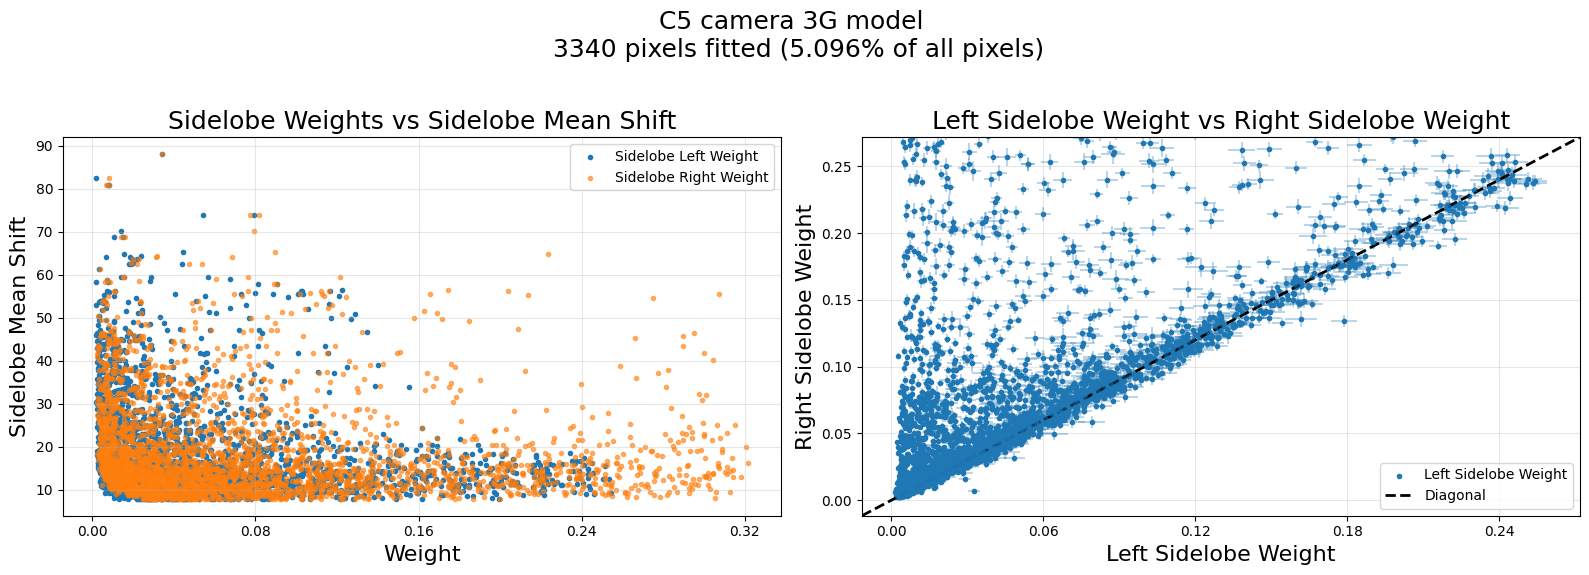

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# For model "3g":
if "3g" in accum:
    print(len(accum["3g"][0]))
    
    # Prepare data for subplot 1:
    # Subplot 1 uses:
    #   Dataset A: x = accum["3g"][0], y = accum["3g"][3]
    #   Dataset B: x = accum["3g"][1], y = accum["3g"][3]
    x_data1_A = np.array(accum["3g"][0])
    y_data1_A = np.array(accum["3g"][3])
    x_err1_A  = np.array(accum_err["3g"][0])
    y_err1_A  = np.array(accum_err["3g"][3])
    weight_label1_A = "Sidelobe Left Weight"
    
    x_data1_B = np.array(accum["3g"][1])
    y_data1_B = np.array(accum["3g"][3])
    x_err1_B  = np.array(accum_err["3g"][1])
    y_err1_B  = np.array(accum_err["3g"][3])
    weight_label1_B = "Sidelobe Right Weight"
    shift_label1   = "Sidelobe Mean Shift"
    
    # Prepare data for subplot 2:
    # Subplot 2 uses:
    #   x = accum["3g"][0] (Left Sidelobe Weight) and
    #   y = accum["3g"][1] (Right Sidelobe Weight)
    x_data2 = np.array(accum["3g"][0])
    y_data2 = np.array(accum["3g"][1])
    x_err2  = np.array(accum_err["3g"][0])
    y_err2  = np.array(accum_err["3g"][1])
    weight_label2 = "Left Sidelobe Weight"
    shift_label2  = "Right Sidelobe Weight"
    
    # Construct title information.
    n_pixels = len(accum["3g"][0])
    percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
    title_str = f"C5 camera 3G model \n {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)"
    
    # Create a figure with 1 row and 2 subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=False)
    
    # --- Subplot 1: Sidelobe Weight vs Sidelobe Mean Shift ---

    ax1.scatter(x_data1_A, y_data1_A, color='C0', marker=".", label=weight_label1_A)
    
    ax1.scatter(x_data1_B, y_data1_B, color='C1', marker=".", alpha=0.6, label=weight_label1_B)
    ax1.legend()
    ax1.set_xlabel("Weight", fontsize=16)
    ax1.set_ylabel(shift_label1, fontsize=16)
    ax1.set_title(f"Sidelobe Weights vs {shift_label1}", fontsize=18)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # --- Subplot 2: Left vs Right Sidelobe Weight with Diagonal ---
    ax2.errorbar(x_data2, y_data2, xerr=x_err2, yerr=y_err2, fmt='.',
                   color='C0', alpha=0.3, markersize=4)
    ax2.scatter(x_data2, y_data2, color='C0', marker=".", label=weight_label2)
    
    ax2.set_xlabel("Left Sidelobe Weight", fontsize=16)
    ax2.set_ylabel("Right Sidelobe Weight", fontsize=16)
    ax2.set_title(f"{weight_label2} vs {shift_label2}", fontsize=18)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # Add a diagonal line to subplot 2.
    lims = ax2.get_xlim()
    ax2.plot(lims, lims, 'k--', lw=2, label="Diagonal")
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)
    plt.legend()
    fig.suptitle(title_str, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"plots/c5_scatter_3g_weight_plots.pdf", format="pdf", bbox_inches='tight')
    plt.show()


706


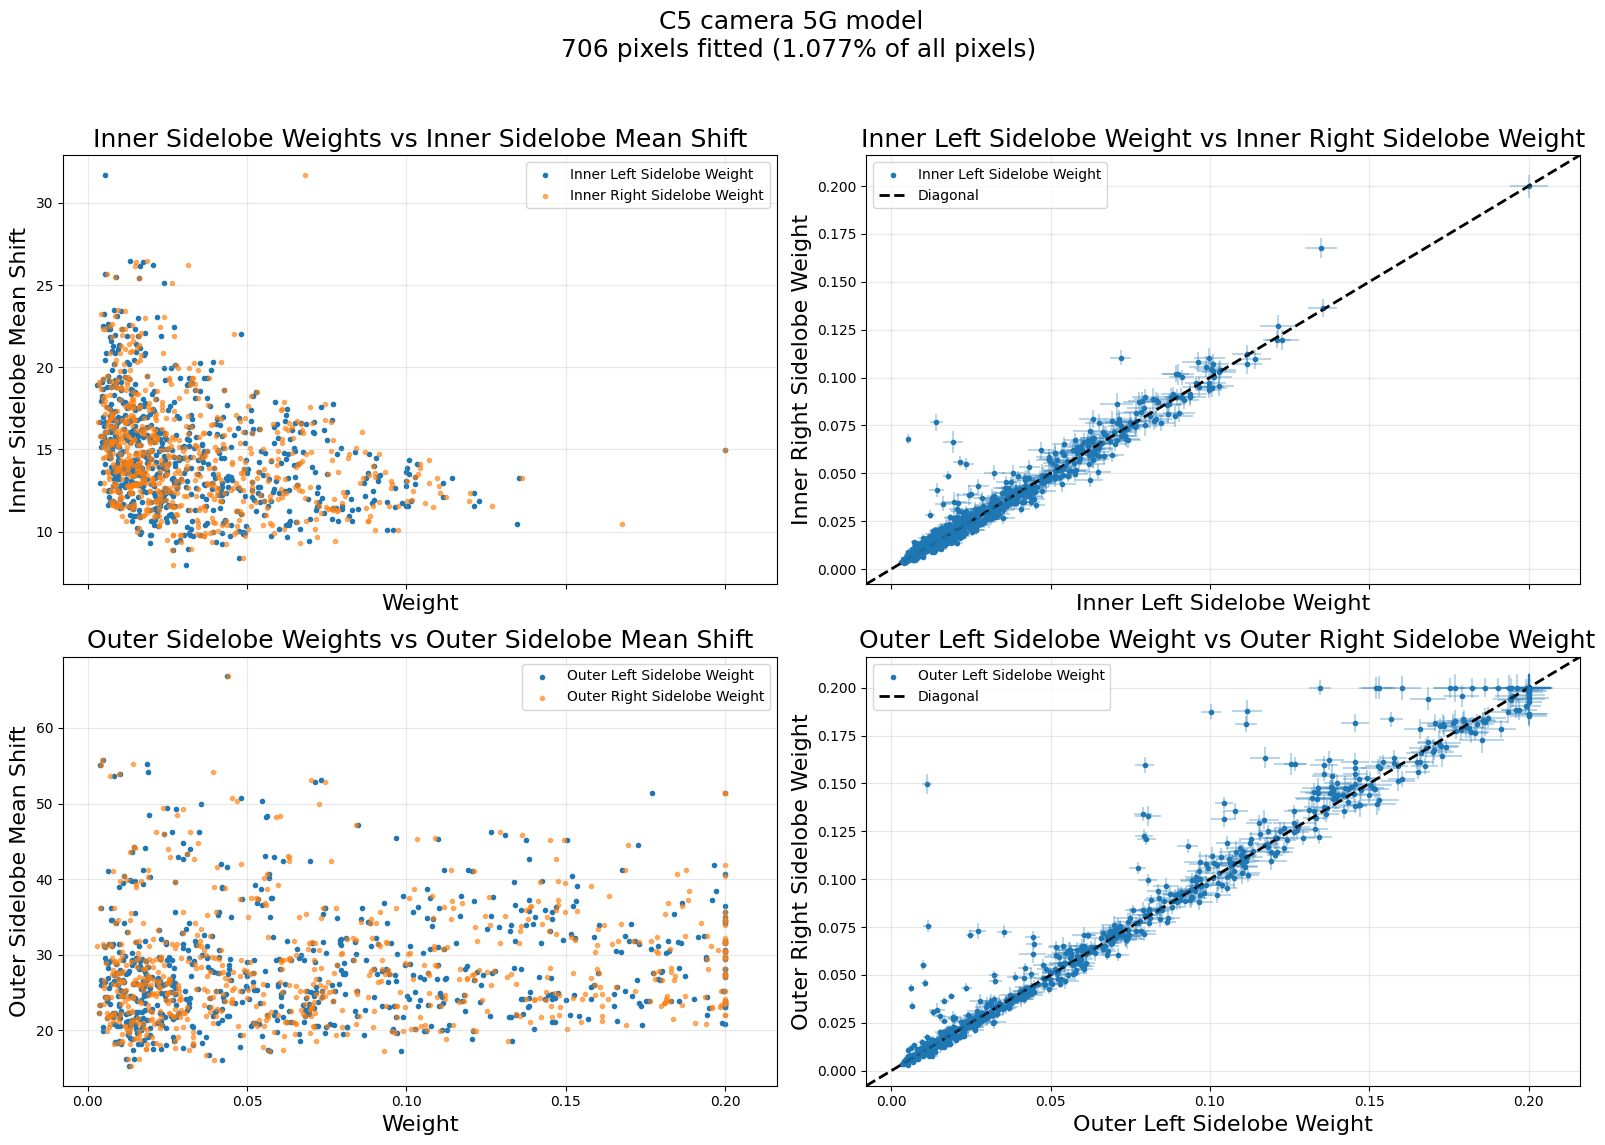

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# For model "5g":
if "5g" in accum:
    print(len(accum["5g"][0]))
    
    # -----------------------------
    # Prepare data for inner subplots:
    # Subplot 1 (Top Left): Sidelobe Weights vs Sidelobe Mean Shift
    #   Dataset A: x = accum["5g"][0] (Inner Left), y = accum["5g"][5] (Inner Shift)
    #   Dataset B: x = accum["5g"][1] (Inner Right), y = accum["5g"][5] (Inner Shift)
    x_data1_A = np.array(accum["5g"][0])
    y_data1_A = np.array(accum["5g"][5])
    x_err1_A  = np.array(accum_err["5g"][0])
    y_err1_A  = np.array(accum_err["5g"][5])
    weight_label1_A = "Inner Left Sidelobe Weight"
    
    x_data1_B = np.array(accum["5g"][1])
    y_data1_B = np.array(accum["5g"][5])
    x_err1_B  = np.array(accum_err["5g"][1])
    y_err1_B  = np.array(accum_err["5g"][5])
    weight_label1_B = "Inner Right Sidelobe Weight"
    shift_label1   = "Inner Sidelobe Mean Shift"
    
    # Subplot 2 (Top Right): Inner Left vs Inner Right Sidelobe Weight with Diagonal
    x_data2 = np.array(accum["5g"][0])
    y_data2 = np.array(accum["5g"][1])
    x_err2  = np.array(accum_err["5g"][0])
    y_err2  = np.array(accum_err["5g"][1])
    weight_label2 = "Inner Left Sidelobe Weight"
    shift_label2  = "Inner Right Sidelobe Weight"
    
    # -----------------------------
    # Prepare data for outer subplots:
    # Subplot 3 (Bottom Left): Outer Sidelobe Weights vs Outer Sidelobe Mean Shift
    #   Dataset A: x = accum["5g"][2] (Outer Left), y = accum["5g"][6] (Outer Shift)
    #   Dataset B: x = accum["5g"][3] (Outer Right), y = accum["5g"][6] (Outer Shift)
    x_data1_A_outer = np.array(accum["5g"][2])
    y_data1_A_outer = np.array(accum["5g"][6])
    x_err1_A_outer  = np.array(accum_err["5g"][2])
    y_err1_A_outer  = np.array(accum_err["5g"][6])
    weight_label1_A_outer = "Outer Left Sidelobe Weight"
    
    x_data1_B_outer = np.array(accum["5g"][3])
    y_data1_B_outer = np.array(accum["5g"][6])
    x_err1_B_outer  = np.array(accum_err["5g"][3])
    y_err1_B_outer  = np.array(accum_err["5g"][6])
    weight_label1_B_outer = "Outer Right Sidelobe Weight"
    shift_label_outer   = "Outer Sidelobe Mean Shift"
    
    # Subplot 4 (Bottom Right): Outer Left vs Outer Right Sidelobe Weight with Diagonal
    x_data2_outer = np.array(accum["5g"][2])
    y_data2_outer = np.array(accum["5g"][3])
    x_err2_outer  = np.array(accum_err["5g"][2])
    y_err2_outer  = np.array(accum_err["5g"][3])
    weight_label2_outer = "Outer Left Sidelobe Weight"
    shift_label2_outer  = "Outer Right Sidelobe Weight"
    
    # Construct title information.
    n_pixels = len(accum["5g"][0])
    percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
    title_str = f"C5 camera 5G model \n {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)"
    
    # -----------------------------
    # Create a figure with 2 rows and 2 columns.
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
    ax1, ax2, ax3, ax4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
    
    # --- Subplot 1 (Top Left): Inner Sidelobe Weight vs Inner Sidelobe Mean Shift ---
    ax1.scatter(x_data1_A, y_data1_A, color='C0', marker=".", label=weight_label1_A)
    ax1.scatter(x_data1_B, y_data1_B, color='C1', marker=".", alpha=0.6, label=weight_label1_B)
    ax1.legend()
    ax1.set_xlabel("Weight", fontsize=16)
    ax1.set_ylabel(shift_label1, fontsize=16)
    ax1.set_title(f"Inner Sidelobe Weights vs {shift_label1}", fontsize=18)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # --- Subplot 2 (Top Right): Inner Left vs Inner Right Sidelobe Weight with Diagonal ---
    ax2.errorbar(x_data2, y_data2, xerr=x_err2, yerr=y_err2, fmt='.',
                 color='C0', alpha=0.3, markersize=4)
    ax2.scatter(x_data2, y_data2, color='C0', marker=".", label=weight_label2)
    ax2.set_xlabel("Inner Left Sidelobe Weight", fontsize=16)
    ax2.set_ylabel("Inner Right Sidelobe Weight", fontsize=16)
    ax2.set_title(f"{weight_label2} vs {shift_label2}", fontsize=18)
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(5))
    lims_inner = ax2.get_xlim()
    ax2.plot(lims_inner, lims_inner, 'k--', lw=2, label="Diagonal")
    ax2.set_xlim(lims_inner)
    ax2.set_ylim(lims_inner)
    ax2.legend()
    
    # --- Subplot 3 (Bottom Left): Outer Sidelobe Weight vs Outer Sidelobe Mean Shift ---
    ax3.scatter(x_data1_A_outer, y_data1_A_outer, color='C0', marker=".", label=weight_label1_A_outer)
    ax3.scatter(x_data1_B_outer, y_data1_B_outer, color='C1', marker=".", alpha=0.6, label=weight_label1_B_outer)
    ax3.legend()
    ax3.set_xlabel("Weight", fontsize=16)
    ax3.set_ylabel(shift_label_outer, fontsize=16)
    ax3.set_title(f"Outer Sidelobe Weights vs {shift_label_outer}", fontsize=18)
    ax3.grid(True, alpha=0.3)
    ax3.xaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # --- Subplot 4 (Bottom Right): Outer Left vs Outer Right Sidelobe Weight with Diagonal ---
    ax4.errorbar(x_data2_outer, y_data2_outer, xerr=x_err2_outer, yerr=y_err2_outer, fmt='.',
                 color='C0', alpha=0.3, markersize=4)
    ax4.scatter(x_data2_outer, y_data2_outer, color='C0', marker=".", label=weight_label2_outer)
    ax4.set_xlabel("Outer Left Sidelobe Weight", fontsize=16)
    ax4.set_ylabel("Outer Right Sidelobe Weight", fontsize=16)
    ax4.set_title(f" {weight_label2_outer} vs {shift_label2_outer}", fontsize=18)
    ax4.grid(True, alpha=0.3)
    ax4.xaxis.set_major_locator(ticker.MaxNLocator(5))
    lims_outer = ax4.get_xlim()
    ax4.plot(lims_outer, lims_outer, 'k--', lw=2, label="Diagonal")
    ax4.set_xlim(lims_outer)
    ax4.set_ylim(lims_outer)
    ax4.legend()
    
    fig.suptitle(title_str, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"plots/c5_scatter_5g_weight_plots.pdf", format="pdf", bbox_inches='tight')
    plt.show()


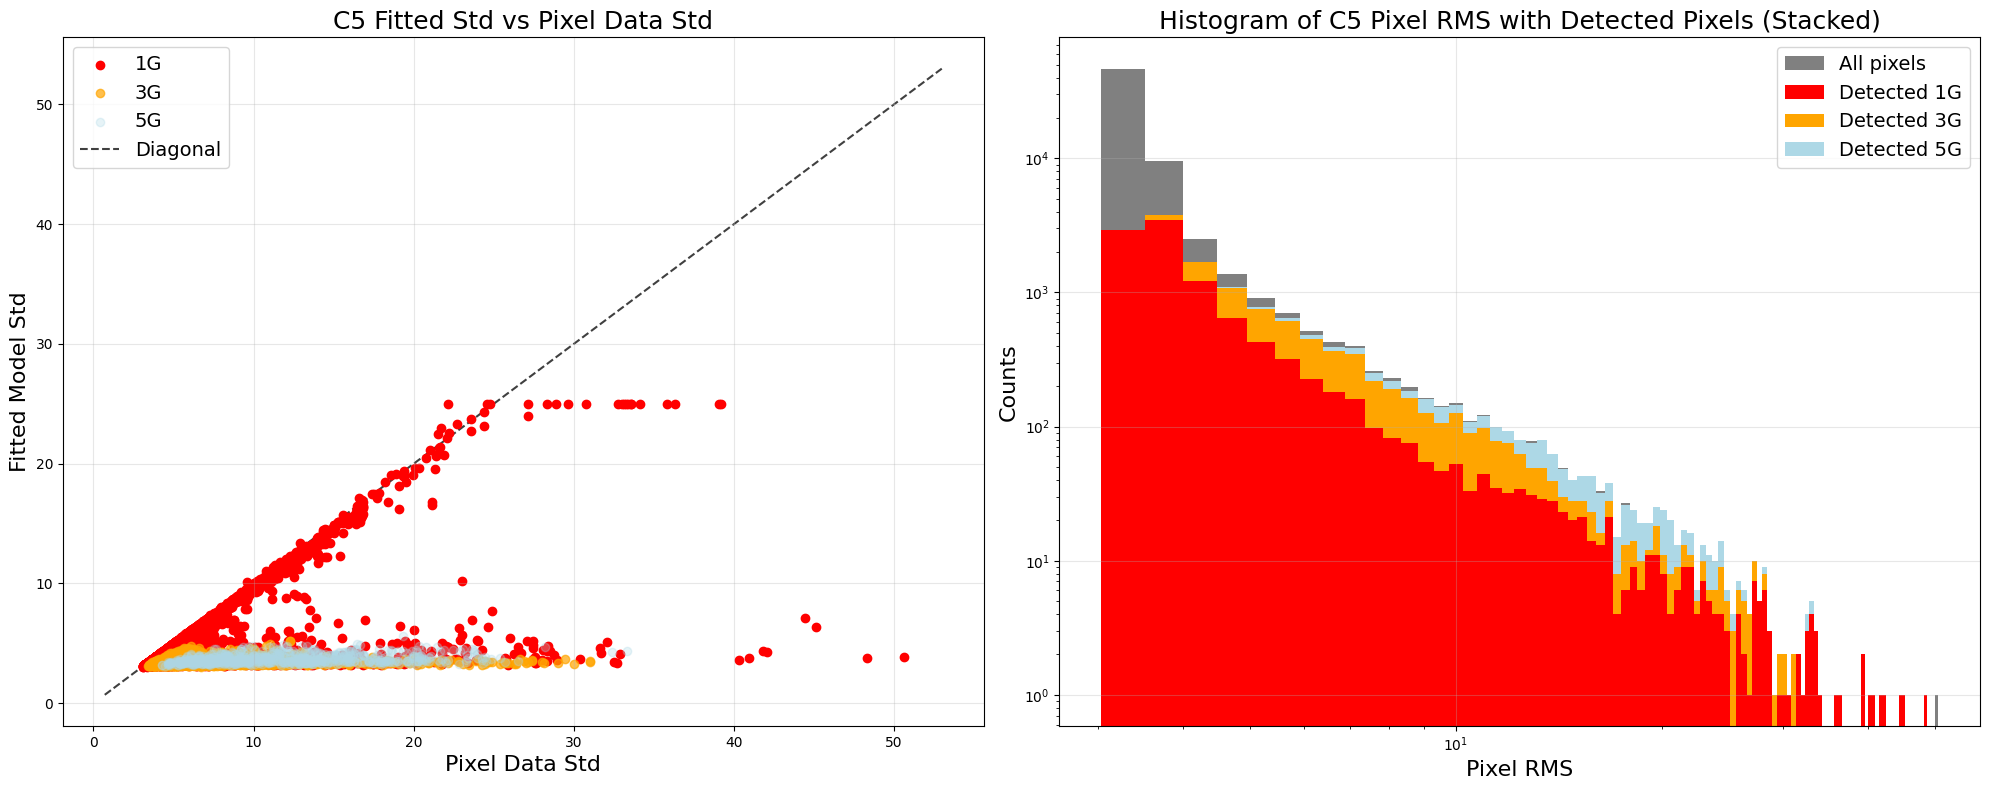

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming that images, std_pixel_list, std_fit_list, models_list, and color_map are already defined.

# Create a figure with two subplots (stacked vertically).
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ----------------------- Scatter Plot with Diagonal Line -----------------------
for model, color in color_map.items():
    # Get indices of results for this model.
    indices = [i for i, m in enumerate(models_list) if m == model]
    if len(indices) == 0:
        continue
    # Extract corresponding std_pixel and std_fit values.
    x_vals = np.array(std_pixel_list)[indices]
    y_vals = np.array(std_fit_list)[indices]

    if model == "1g":
        alpha = 1
        
    elif model == "3g":
        alpha = 0.7

    elif model == "5g":
        alpha = 0.3 

    
    ax1.scatter(x_vals, y_vals, color=color, alpha=alpha, edgecolor=None,
                label=model.upper())

ax1.set_xlabel("Pixel Data Std", fontsize=16)
ax1.set_ylabel("Fitted Model Std", fontsize=16)
ax1.set_title("C5 Fitted Std vs Pixel Data Std", fontsize=18)
ax1.grid(True, alpha=0.3)

# Compute limits for the diagonal line (y = x).
x_limits = ax1.get_xlim()
y_limits = ax1.get_ylim()
lower_limit = min(x_limits[0], y_limits[0])
upper_limit = max(x_limits[1], y_limits[1])
ax1.plot([lower_limit, upper_limit], [lower_limit, upper_limit],
         'k--', alpha=0.75, zorder=0,label = "Diagonal")
ax1.legend(fontsize=14)


# ----------------------- Histogram Overlay Plot -----------------------
# Compute overall pixel RMS for the entire sensor.
# Assume images is a 3D array with shape (n_frames, height, width)
pixel_rms = np.std(images, axis=0)  # RMS computed across frames for each pixel.
all_rms = pixel_rms.flatten()

# Define bins for the histogram (adjust the number of bins as needed).
bins = np.linspace(np.min(all_rms), np.max(all_rms), 100)

# Plot the histogram for all pixels in light gray.
ax2.hist(all_rms, bins=bins, color='gray', alpha=1,
         label='All pixels', density=False)

# Prepare lists for data, labels, and colors for each model.
data_list = []
labels_list = []
colors_list = []

# For each model in our desired order:
for model in ["1g", "3g", "5g"]:
    # Find indices for detected pixels that were fitted with this model.
    indices = [i for i, m in enumerate(models_list) if m == model]
    if len(indices) == 0:
        continue
    # Extract RMS values for these detected pixels.
    rms_model = np.array(std_pixel_list)[indices]
    data_list.append(rms_model)
    
    # Set color and label according to model.
    if model == "1g":
        labels_list.append(f"Detected {model.upper()}")
        colors_list.append(color_map[model])
    elif model == "3g":
        labels_list.append(f"Detected {model.upper()}")
        colors_list.append(color_map[model])
    elif model == "5g":
        labels_list.append(f"Detected {model.upper()}")
        colors_list.append(color_map[model])

# Create a figure for the stacked histogram.
ax2.hist(data_list, bins=bins, stacked=True, histtype="bar", color=colors_list,
         label=labels_list, density=False)
plt.xlabel("Pixel RMS", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Histogram of C5 Pixel RMS with Detected Pixels (Stacked)", fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig("plots/c5_fit_std_hist.pdf", format="pdf", bbox_inches='tight')
plt.show()



Model 1g:
  Param 0: median = 0.9990, mean = 0.9990, std = 0.0000
  Param 1: median = -0.1103, mean = -0.0581, std = 0.4008
  Param 2: median = 3.4993, mean = 4.1231, std = 2.0708
Model 3g:
  Param 0: median = 0.0281, mean = 0.0475, std = 0.0509
  Param 1: median = 0.0492, mean = 0.0753, std = 0.0738
  Param 2: median = -0.2544, mean = -0.2018, std = 0.4867
  Param 3: median = 14.6886, mean = 18.4601, std = 10.7989
  Param 4: median = 3.3776, mean = 3.4370, std = 0.2360
Model 5g:
  Param 0: median = 0.0224, mean = 0.0319, std = 0.0265
  Param 1: median = 0.0233, mean = 0.0330, std = 0.0271
  Param 2: median = 0.0567, mean = 0.0731, std = 0.0595
  Param 3: median = 0.0603, mean = 0.0760, std = 0.0610
  Param 4: median = -0.1436, mean = -0.0673, std = 0.3456
  Param 5: median = 14.1864, mean = 14.7302, std = 3.2938
  Param 6: median = 26.7146, mean = 28.3019, std = 7.5230
  Param 7: median = 3.6071, mean = 3.7076, std = 0.3608


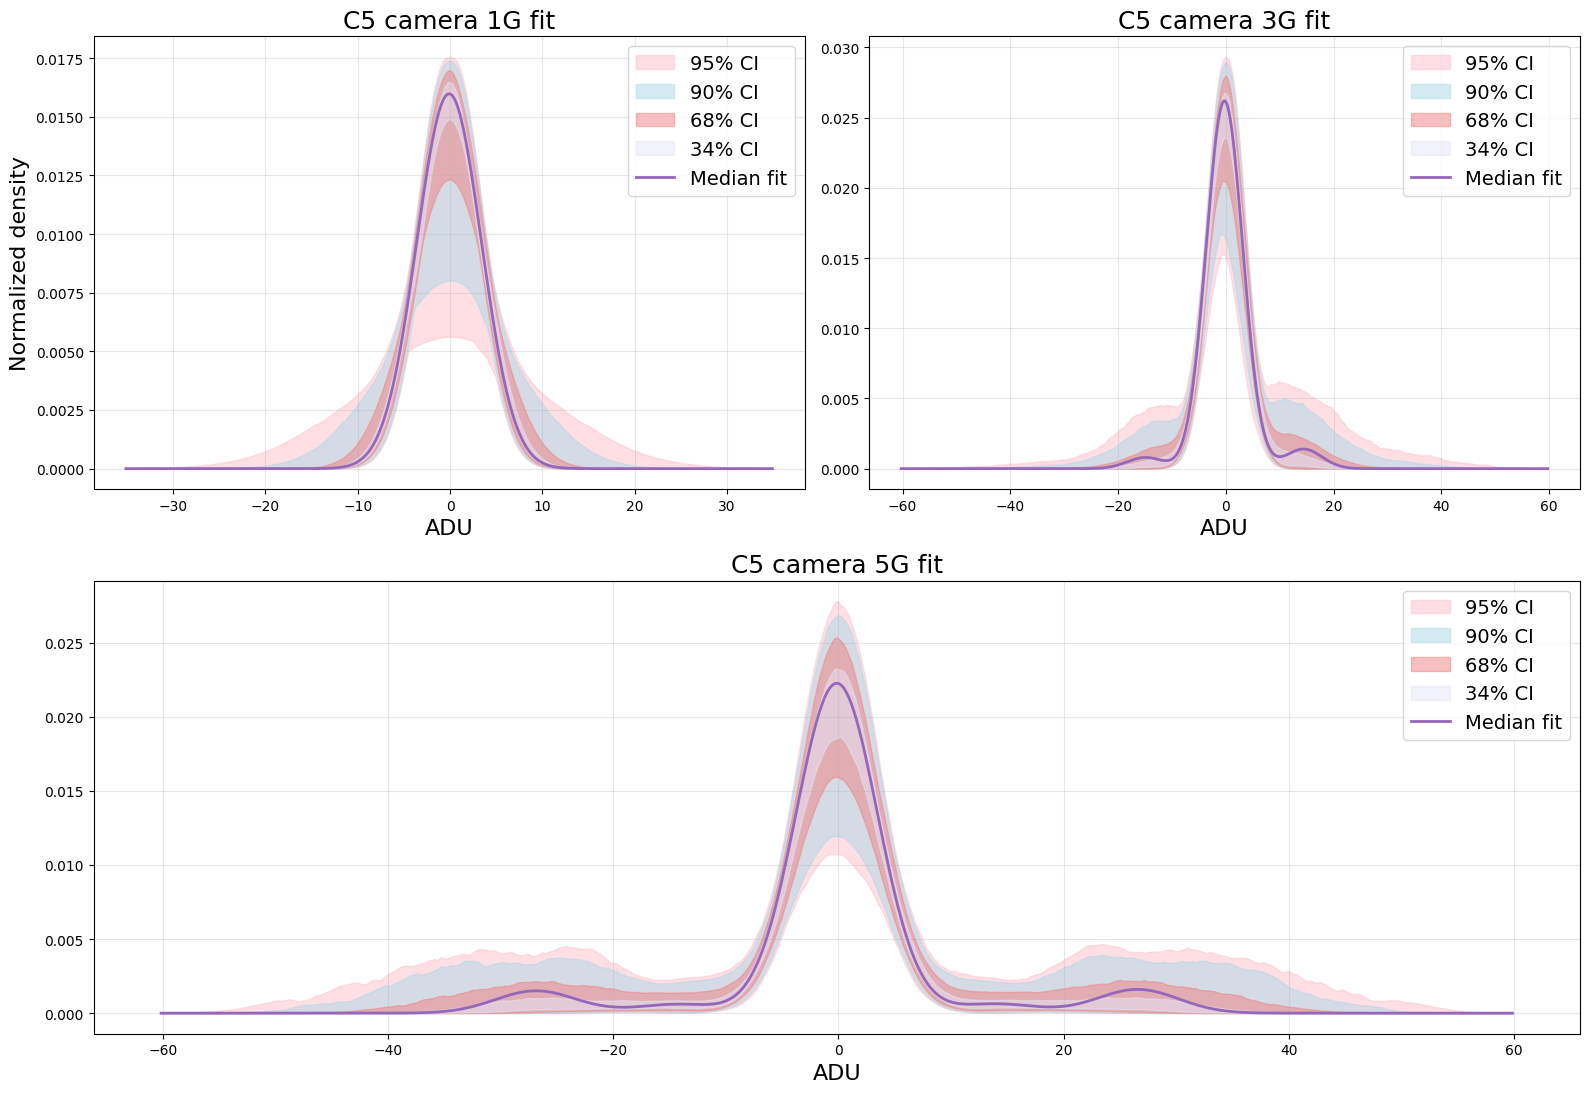

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

def plot_gaussian_fit_empirical(model, all_params, ax, x_range_factor=50, label=True):
    """
    Plot the Gaussian mixture fit for the given model using the full empirical
    set of fitted parameters (all_params, a 2D array of shape (N, n_params)) on the provided axis.
    The function computes confidence intervals (95%, 90%, 68%, 34%) directly from the data and overlays them
    on the median fit (computed from the median parameters).
    
    Parameters:
      model: str, one of "1g", "2g", "3g", or "5g".
      all_params: 2D numpy array of shape (N, n_params) containing the fitted parameters for each pixel.
      ax: matplotlib.axes.Axes on which to plot.
      x_range_factor: determines the x-axis range relative to the median "center".
    """
    # Compute median, mean, and std from the empirical data:
    median_params = np.median(all_params, axis=0)
    mean_params   = np.mean(all_params, axis=0)
    std_params    = np.std(all_params, axis=0)
    n_params = len(median_params)
    
    # Set up x values based on the "center" and a fixed range.
    if model == "1g":
        center = median_params[1]  # m1
        x_vals = np.linspace(center - x_range_factor, center + x_range_factor, 500)
        y_median = gaussian_1(x_vals, median_params[0], median_params[1], median_params[2])
    elif model == "2g":
        center = median_params[1]  # m
        x_vals = np.linspace(center - x_range_factor, center + x_range_factor, 500)
        y_median = gaussian2_pos(x_vals, median_params[0], median_params[1],
                                 median_params[2], median_params[3])
    elif model == "3g":
        center = median_params[2]  # m
        x_vals = np.linspace(center - x_range_factor, center + x_range_factor, 500)
        y_median = gaussian_3(x_vals, median_params[0], median_params[1],
                              median_params[2], median_params[3], median_params[4])
    elif model == "5g":
        center = median_params[4]  # m
        x_vals = np.linspace(center - x_range_factor, center + x_range_factor, 500)
        y_median = gaussian_5(x_vals, median_params[0], median_params[1],
                              median_params[2], median_params[3], median_params[4],
                              median_params[5], median_params[6], median_params[7])
    else:
        raise ValueError(f"Unknown model: {model}")
    
    # Evaluate the Gaussian mixture for each fitted parameter set.
    curves = []
    for params in all_params:
        if model == "1g":
            y_sample = gaussian_1(x_vals, params[0], params[1], params[2])
        elif model == "2g":
            y_sample = gaussian2_pos(x_vals, params[0], params[1], params[2], params[3])
        elif model == "3g":
            y_sample = gaussian_3(x_vals, params[0], params[1], params[2], params[3], params[4])
        elif model == "5g":
            y_sample = gaussian_5(x_vals, params[0], params[1], params[2],
                                  params[3], params[4], params[5], params[6], params[7])
        curves.append(y_sample)
    curves = np.array(curves)  # Shape: (N, len(x_vals))
    
    # Define confidence levels and corresponding colors.
    conf_levels = [95, 90, 68, 34]  # in percent
    conf_colors = {95: 'pink', 90: 'lightblue', 68: 'lightcoral', 34:'lavender'}
    
    # Plot the empirical confidence envelopes.
    for conf in sorted(conf_levels, reverse=True):
        lower_pct = (100 - conf) / 2
        upper_pct = 100 - lower_pct
        lower = np.percentile(curves, lower_pct, axis=0)
        upper = np.percentile(curves, upper_pct, axis=0)
        ax.fill_between(x_vals, lower, upper, color=conf_colors[conf], alpha=0.5,
                        label=f"{conf}% CI")
    
    # Plot the median fit on top.
    ax.plot(x_vals, y_median, color='C4', lw=2, label="Median fit")
    ax.set_xlabel("ADU", fontsize=16)
    if label:
        ax.set_ylabel("Normalized density", fontsize=16)
    ax.set_title(f"C5 camera {model.upper()} fit", fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=14)
    

# Create a figure using GridSpec:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
# Top row: two subplots.
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# Bottom row: one subplot spanning both columns.
ax3 = fig.add_subplot(gs[1, :])
axes = [ax1, ax2, ax3]

# Loop over models "1g", "3g", and "5g". 
# They will be plotted in order: first on ax1, second on ax2, third on ax3.
for i, model in enumerate(["1g", "3g", "5g"]):
    if model not in accum:
        continue
    n_params = len(accum[model])
    all_params = np.column_stack([np.array(accum[model][j]) for j in range(n_params)])
    
    print(f"Model {model}:")
    for j in range(n_params):
        print(f"  Param {j}: median = {np.median(accum[model][j]):.4f}, mean = {np.mean(accum[model][j]):.4f}, std = {np.std(accum[model][j]):.4f}")
    
    # Choose the x_range based on the model.
    x_range = 35 if model == "1g" else 60
    # For the first model, we want the legend (label=True). For the others, you can set label=False.
    label_flag = True if i == 0 else False
    
    # Plot the Gaussian fit empirical results onto the corresponding axis.
    plot_gaussian_fit_empirical(model, all_params, axes[i], x_range_factor=x_range, label=label_flag)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plots/combined_c5_gaussian_fit_empirical.pdf", format="pdf", bbox_inches="tight")
plt.show()


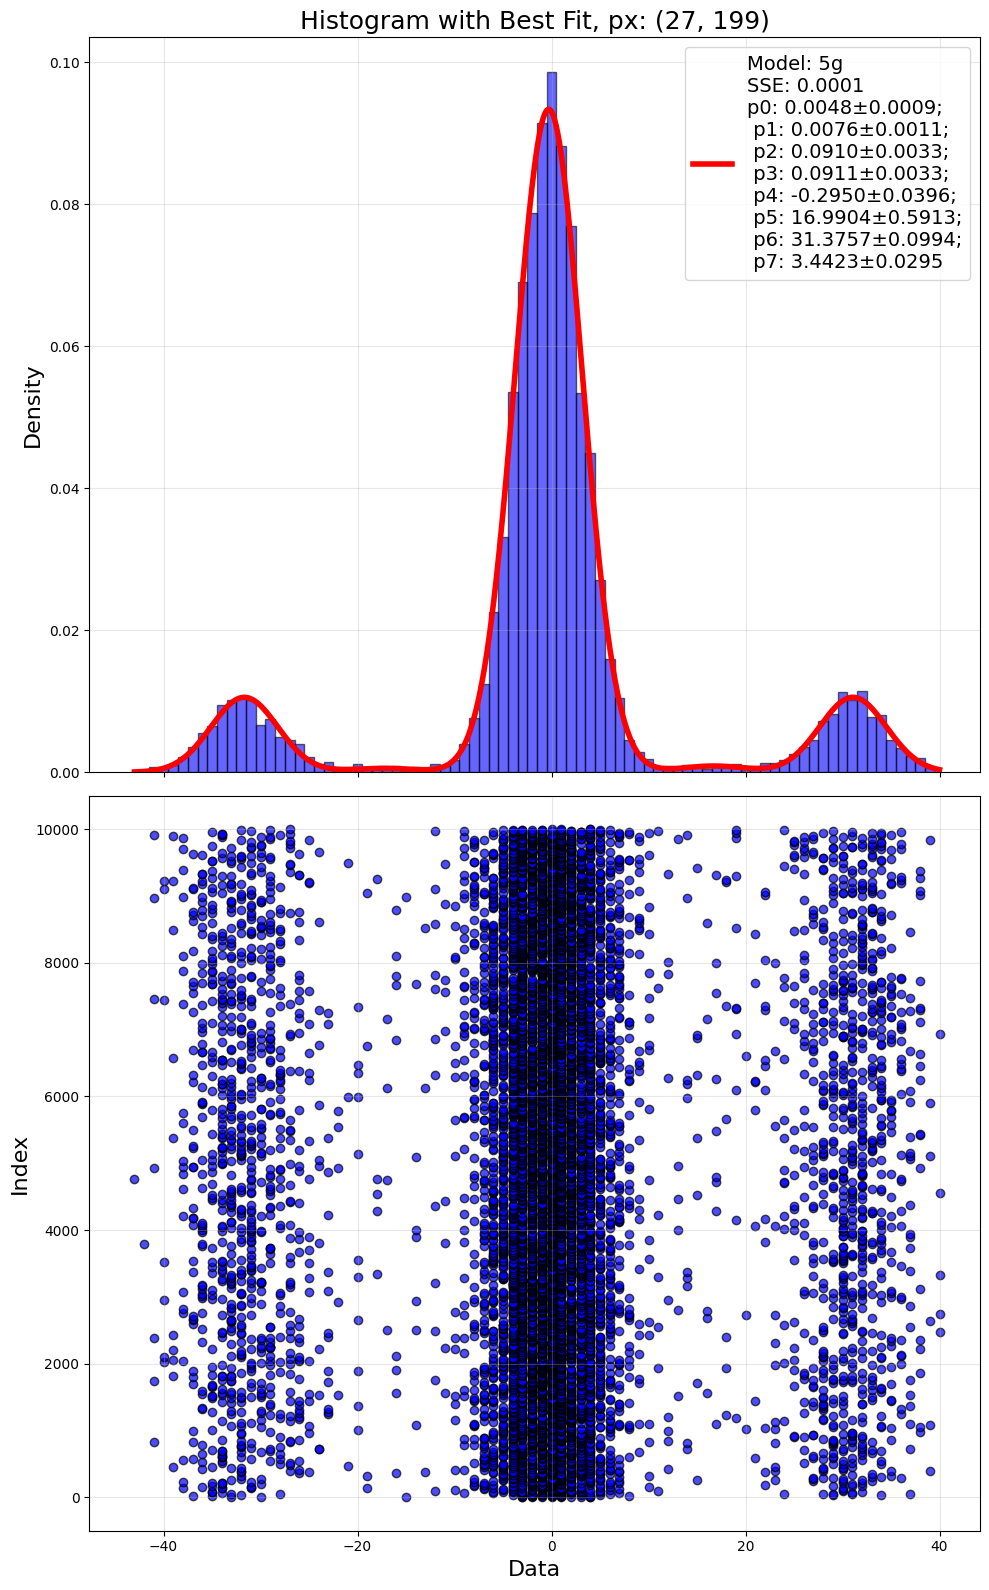

In [16]:

# Randomly select 100 items (or all if there are less than 100)
selected_results = random.sample(all_results, min(10, len(all_results)))

i = 0
# Iterate over the selected results
for res in selected_results:
#for key,res in changed_results.items():
    i+=1
    key = res["idx"]
    y,x = key

    if res["best_model"] == "5g":
        pass
    else:
        continue

        
    data = images[:,y,x]

    best_model = res["best_model"]

    # Create histogram bins from data
    data_min, data_max = np.min(data), np.max(data)
    bins = np.arange(data_min - 0.5, data_max + 0.5, 1.0)
    if len(bins) < 2:
        bins = np.linspace(data_min, data_max, 20)

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 16))

    # Top subplot: Vertical histogram with best fitted Gaussian mixture curve.
    ax1.hist(data, bins=bins, density=True, alpha=0.6, color='blue', edgecolor='black')
    x_fine = np.linspace(data_min, data_max, 1000)
    # Retrieve the best-fit parameters and corresponding Gaussian function.
    popt_best, pcov_best, sse_best, _, _, best_gauss_func = res[best_model]
    y_best = best_gauss_func(x_fine, *popt_best)
    y_best = y_best / (np.mean(np.diff(x_fine)))
    err = np.sqrt(np.diag(pcov_best))
    # Create a string with parameter values and errors.
    params_str = ";\n ".join([f"p{i}: {p:.4f}±{e:.4f}" for i, (p, e) in enumerate(zip(popt_best, err))])
    label_text = f"Model: {best_model}\nSSE: {sse_best:.4f}\n{params_str}"
    ax1.plot(x_fine, y_best, 'r-', lw=4, label=label_text)
    ax1.set_ylabel("Density", fontsize=16)
    ax1.set_title(f"Histogram with Best Fit, px: {y,x}", fontsize=18)
    ax1.legend(fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Bottom subplot: Scatter plot of the raw data.
    # Here, the x-axis (data values) is shared with the histogram.
    ax2.scatter(data, range(len(data)), color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel("Data", fontsize=16)
    ax2.set_ylabel("Index", fontsize=16)
    # No title is set for the scatter plot.
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()








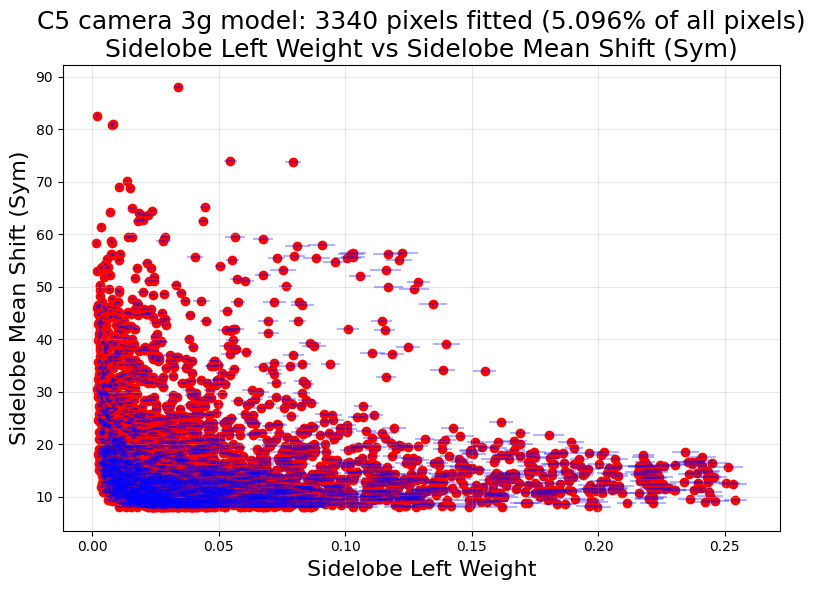

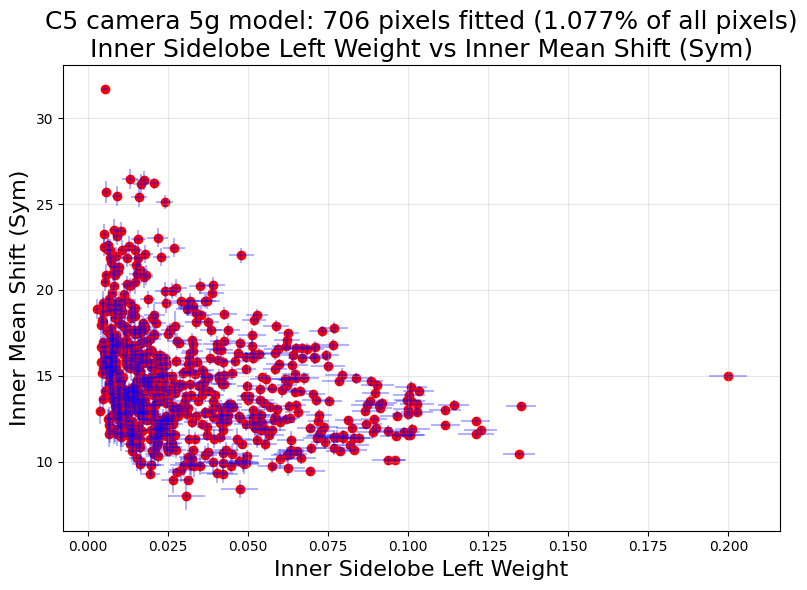

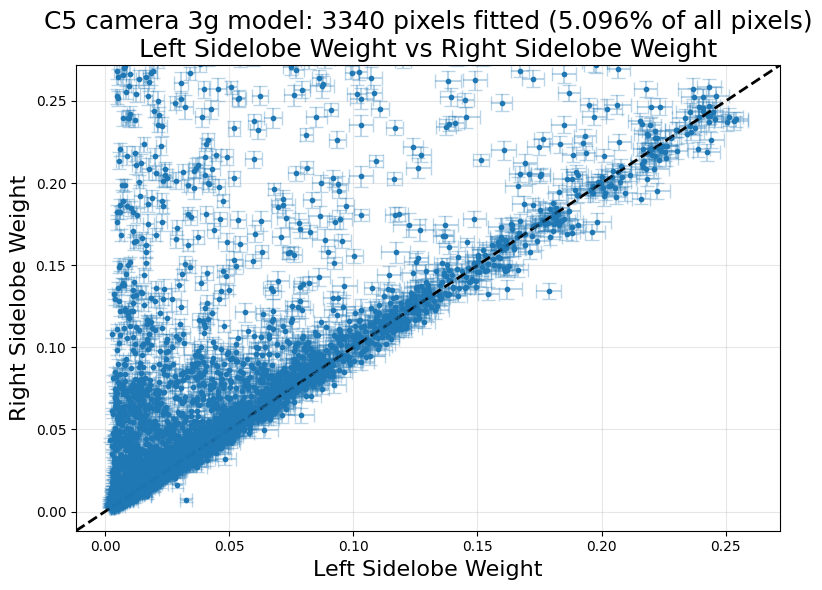

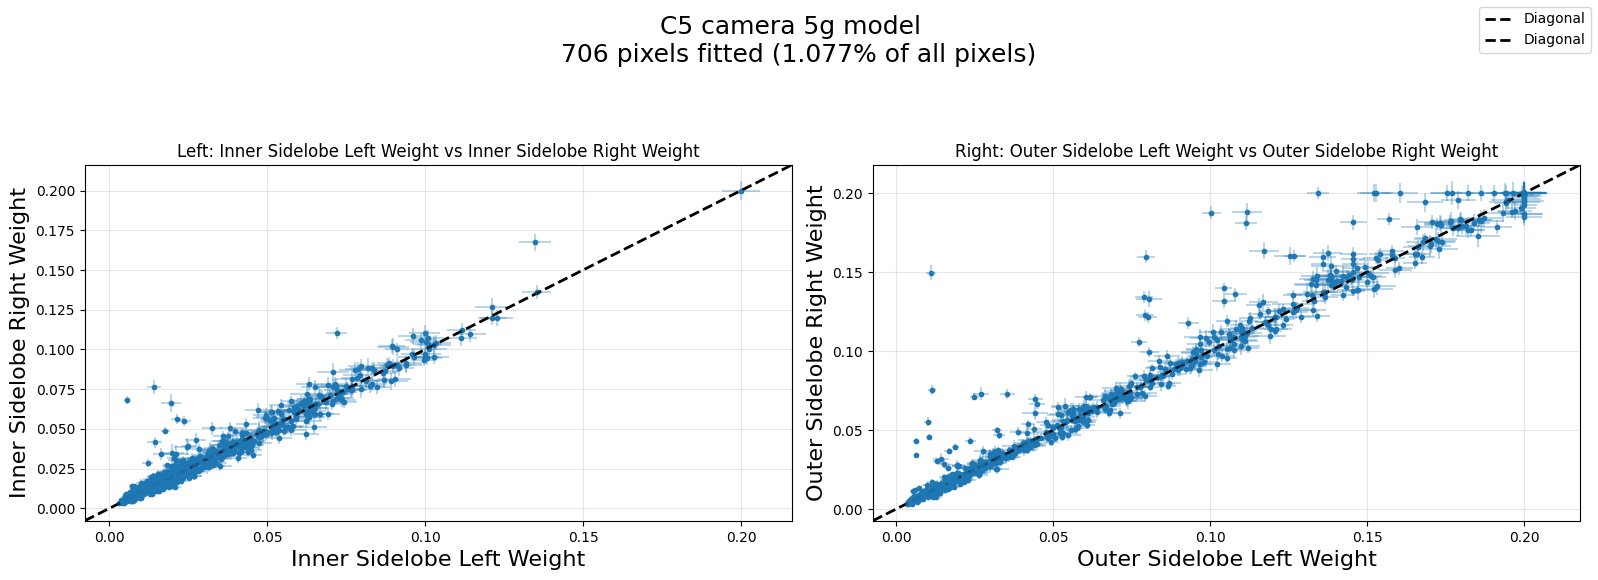

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# List of models to check.
models = ["1g", "2g_pos", "2g_neg", "3g", "5g"]

# Accumulate fitted parameters and their errors in nested dictionaries.
# For each model (or combined key), 
#    accum[model][i] holds all popt values for parameter i,
#    accum_err[model][i] holds all error values for parameter i.
accum = {}
accum_err = {}
for res in all_results:
    for m in models:
        if m == res["best_model"]:
            # For 2g models, combine under key "2g"
            key = "2g" if m in ["2g_pos", "2g_neg"] else m
            popt = res[m][0]
            perr = np.sqrt(np.diag(res[m][1]))
            # If model is 2g_neg, convert the second parameter (index 1) to negative.
            if m == "2g_neg":
                popt = list(popt)
                popt[1] = -popt[1]
            if key not in accum:
                n = len(popt)
                accum[key] = {i: [] for i in range(n)}
                accum_err[key] = {i: [] for i in range(n)}
            for i, val in enumerate(popt):
                accum[key][i].append(val)
            for i, err_val in enumerate(perr):
                accum_err[key][i].append(err_val)

# Compute total number of fitted pixels over all models.
fit_pixels = sum(len(accum[k][0]) for k in accum)
total_pixels = multip * multip  # assume multip is defined elsewhere

# Now, for models "2g", "3g", and "5g", create scatter plots of weight vs mean_shift.
for m in ["2g", "3g", "5g"]:
    if m not in accum:
        continue
    # For each model, choose the parameter indices for weight (x) and mean shift (y)
    if m == "2g":
        # 2g: x = Center Weight (index 0), y = Mean Shift (index 2)
        x_data = 1.0 - np.array(accum[m][0])
        y_data = np.array(accum[m][2])
        x_err  = np.array(accum_err[m][0])
        y_err  = np.array(accum_err[m][2])
        weight_label = "Sidelobe Weight"
        shift_label = "Mean Shift"
    elif m == "3g":
        # 3g: x = Sidelobe Left Weight (index 0), y = Sidelobe Mean Shift (Sym) (index 3)
        x_data = np.array(accum[m][0])
        y_data = np.array(accum[m][3])
        x_err  = np.array(accum_err[m][0])
        y_err  = np.array(accum_err[m][3])
        weight_label = "Sidelobe Left Weight"
        shift_label = "Sidelobe Mean Shift (Sym)"
    elif m == "5g":
        # 5g: x = Inner Sidelobe Left Weight (index 0), y = Inner Mean Shift (Sym) (index 5)
        x_data = np.array(accum[m][0])
        y_data = np.array(accum[m][5])
        x_err  = np.array(accum_err[m][0])
        y_err  = np.array(accum_err[m][5])
        weight_label = "Inner Sidelobe Left Weight"
        shift_label = "Inner Mean Shift (Sym)"
    
    # Create the scatter plot with error bars in both directions.
    plt.figure(figsize=(8,6))
    plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='.',
                 capsize=None, color='blue', alpha=0.3, markersize=0)
    
    plt.scatter(x_data, y_data,
                color='red')
    plt.xlabel(weight_label, fontsize=16)
    plt.ylabel(shift_label, fontsize=16)
    
    # Construct a suptitle that includes the number of pixels and percentages.
    n_pixels = len(accum[m][0])
    if m == "1g":
        percentage = (n_pixels / fit_pixels * 100) if total_pixels > 0 else 0
        title_str = f"C5 camera {m} model: {n_pixels} pixels fitted ({percentage:.3f}% of fitted pixels)"
    else:
        percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
        title_str = f"C5 camera {m} model: {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)"
    
    plt.title(f"{title_str}\n{weight_label} vs {shift_label}", fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f"plots/c5_scatter_{m}_weight_vs_meanshift.png", format="png", dpi=600, bbox_inches='tight')
    plt.savefig(f"plots/c5_scatter_{m}_weight_vs_meanshift.pdf", format="pdf", bbox_inches='tight')
    plt.show()


for m in ["3g", "5g"]:
    if m not in accum:
        continue
    if m == "3g":
        # For model "3g": 
        # x = Inner Sidelobe Left Weight (index 0), y = Inner Sidelobe Right Weight (index 1)
        x_data = np.array(accum[m][0])
        y_data = np.array(accum[m][1])
        x_err  = np.array(accum_err[m][0])
        y_err  = np.array(accum_err[m][1])
        weight_label = "Left Sidelobe Weight"
        shift_label = "Right Sidelobe Weight"
    
        # Create the scatter plot with error bars.
        plt.figure(figsize=(8,6))
        plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='.',
                     capsize=5, color='C0', alpha=0.3)
        plt.scatter(x_data, y_data, color='C0', marker=".")
        plt.xlabel(weight_label, fontsize=16)
        plt.ylabel(shift_label, fontsize=16)
        
        # Add a diagonal line.
        ax = plt.gca()
        lims = ax.get_xlim()
        ax.plot(lims, lims, 'k--', lw=2,label="Diagonal")
        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
        # Construct title information.
        n_pixels = len(accum[m][0])
        percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
        title_str = f"C5 camera {m} model: {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)"
        plt.title(f"{title_str}\n{weight_label} vs {shift_label}", fontsize=18)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"plots/c5_scatter_{m}_lr_weight.pdf", format="pdf", bbox_inches='tight')
        plt.show()
    
    elif m == "5g":
        # For model "5g":
        # Left subplot: Inner Sidelobe Weights (indices 0 and 1)
        x_data_left = np.array(accum[m][0])   # Inner Sidelobe Left Weight (index 0)
        y_data_left = np.array(accum[m][1])     # Inner Sidelobe Right Weight (index 1)
        x_err_left  = np.array(accum_err[m][0])
        y_err_left  = np.array(accum_err[m][1])
        weight_label_left = "Inner Sidelobe Left Weight"
        shift_label_left  = "Inner Sidelobe Right Weight"
        
        # Right subplot: Outer Sidelobe Weights (indices 2 and 3)
        x_data_right = np.array(accum[m][2])    # Outer Sidelobe Left Weight (index 2)
        y_data_right = np.array(accum[m][3])      # Outer Sidelobe Right Weight (index 3)
        x_err_right  = np.array(accum_err[m][2])
        y_err_right  = np.array(accum_err[m][3])
        weight_label_right = "Outer Sidelobe Left Weight"
        shift_label_right  = "Outer Sidelobe Right Weight"
        
        # Create a figure with two subplots side by side.
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left subplot: Inner weights.
        ax1.errorbar(x_data_left, y_data_left, xerr=x_err_left, yerr=y_err_left, fmt='.',
                     capsize=None, color='C0', alpha=0.3)
        ax1.scatter(x_data_left, y_data_left, color='C0', marker=".")
        ax1.set_xlabel(weight_label_left, fontsize=16)
        ax1.set_ylabel(shift_label_left, fontsize=16)
        ax1.grid(True, alpha=0.3)
        ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
        # Add diagonal line to left subplot.
        lims1 = ax1.get_xlim()
        ax1.plot(lims1, lims1, 'k--', lw=2,label="Diagonal")
        ax1.set_xlim(lims1)
        ax1.set_ylim(lims1)
        ax1.set_title(f"Left: {weight_label_left} vs {shift_label_left}")
        
        # Right subplot: Outer weights.
        ax2.errorbar(x_data_right, y_data_right, xerr=x_err_right, yerr=y_err_right, fmt='.',
                     capsize=None, color='C0', alpha=0.3)
        ax2.scatter(x_data_right, y_data_right, color='C0', marker=".")
        ax2.set_xlabel(weight_label_right, fontsize=16)
        ax2.set_ylabel(shift_label_right, fontsize=16)
        ax2.grid(True, alpha=0.3)
        ax2.xaxis.set_major_locator(ticker.MaxNLocator(5))
        # Add diagonal line to right subplot.
        lims2 = ax2.get_xlim()
        ax2.plot(lims2, lims2, 'k--', lw=2,label="Diagonal")
        ax2.set_xlim(lims2)
        ax2.set_ylim(lims2)
        ax2.set_title(f"Right: {weight_label_right} vs {shift_label_right}")

        fig.legend()
        # Construct title information.
        n_pixels = len(accum[m][0])
        percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
        title_str = f"C5 camera {m} model \n {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)"
        suptitle = (f"{title_str}\n")
        
        fig.suptitle(suptitle, fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"plots/c5_scatter_{m}_inner_outer_lr_weight.pdf", format="pdf", bbox_inches='tight')
        plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


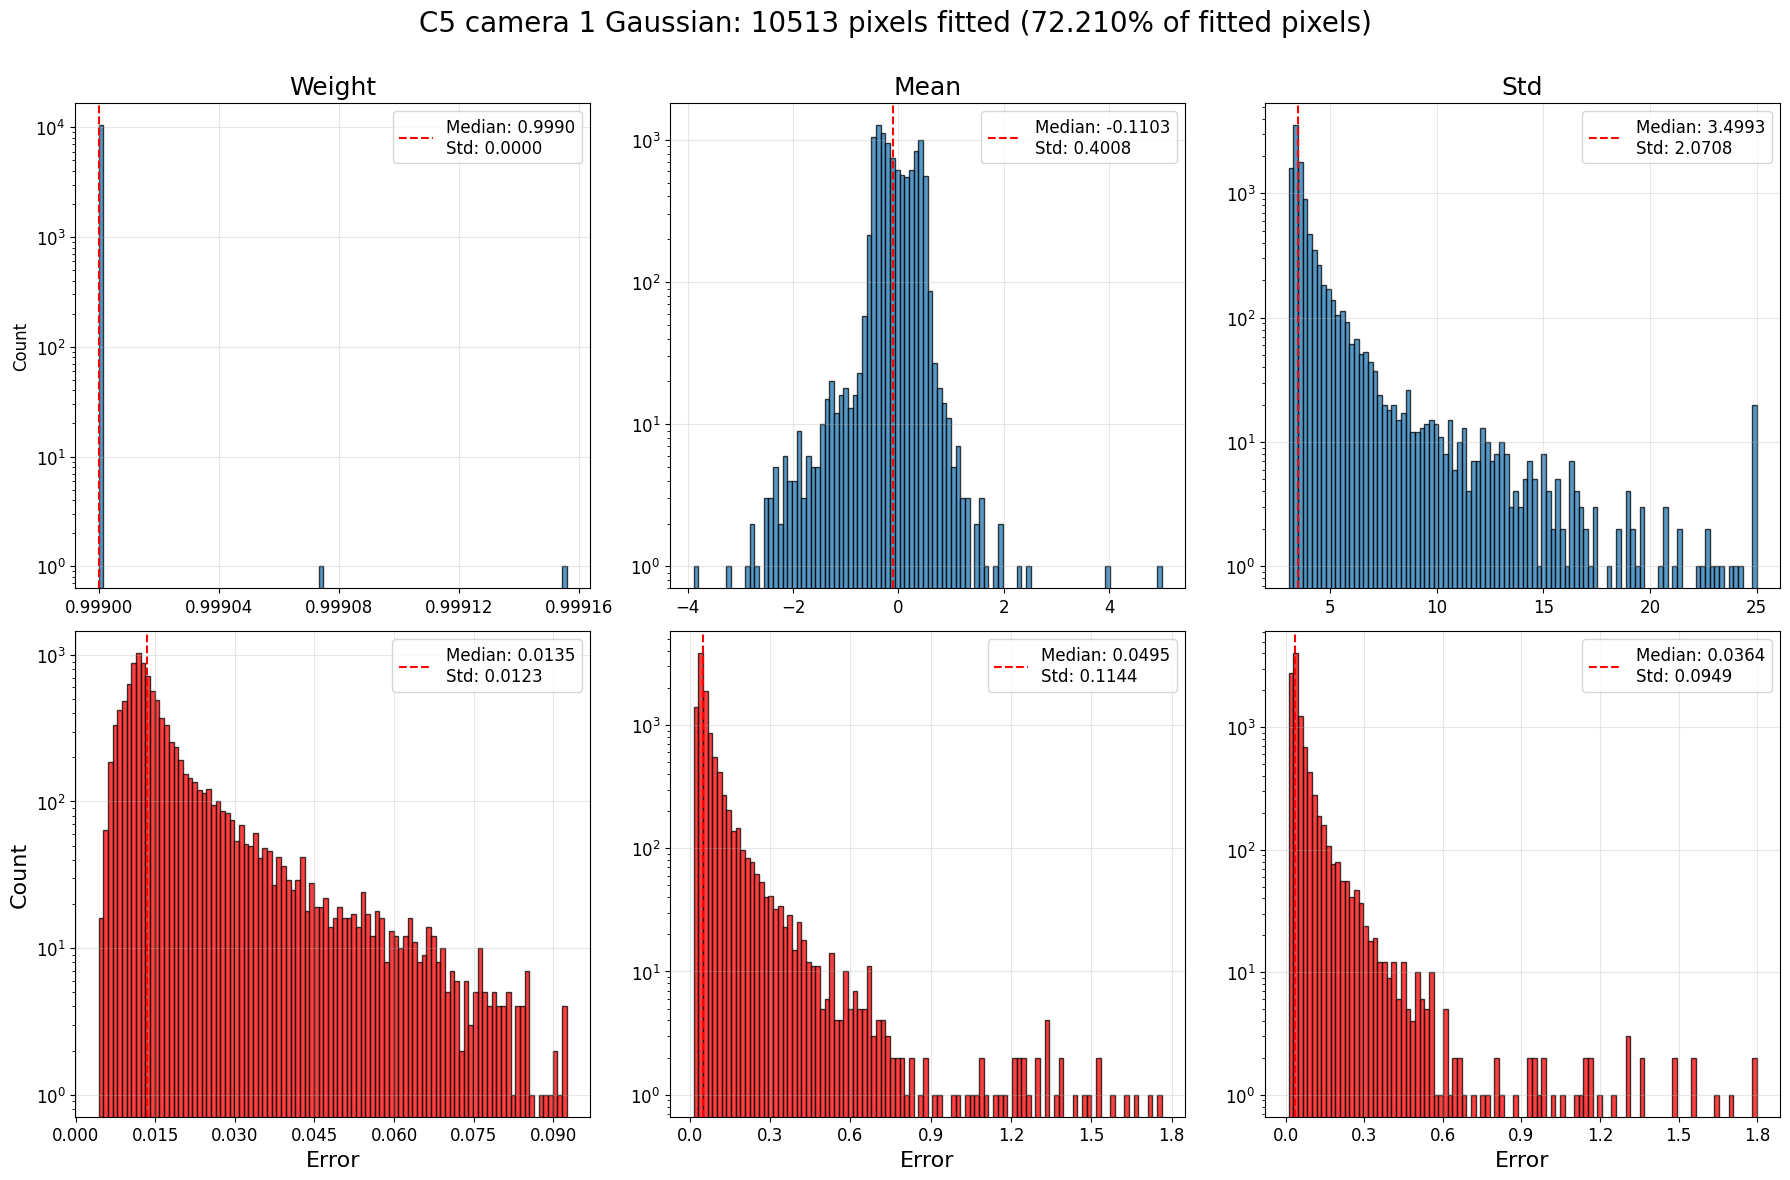

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


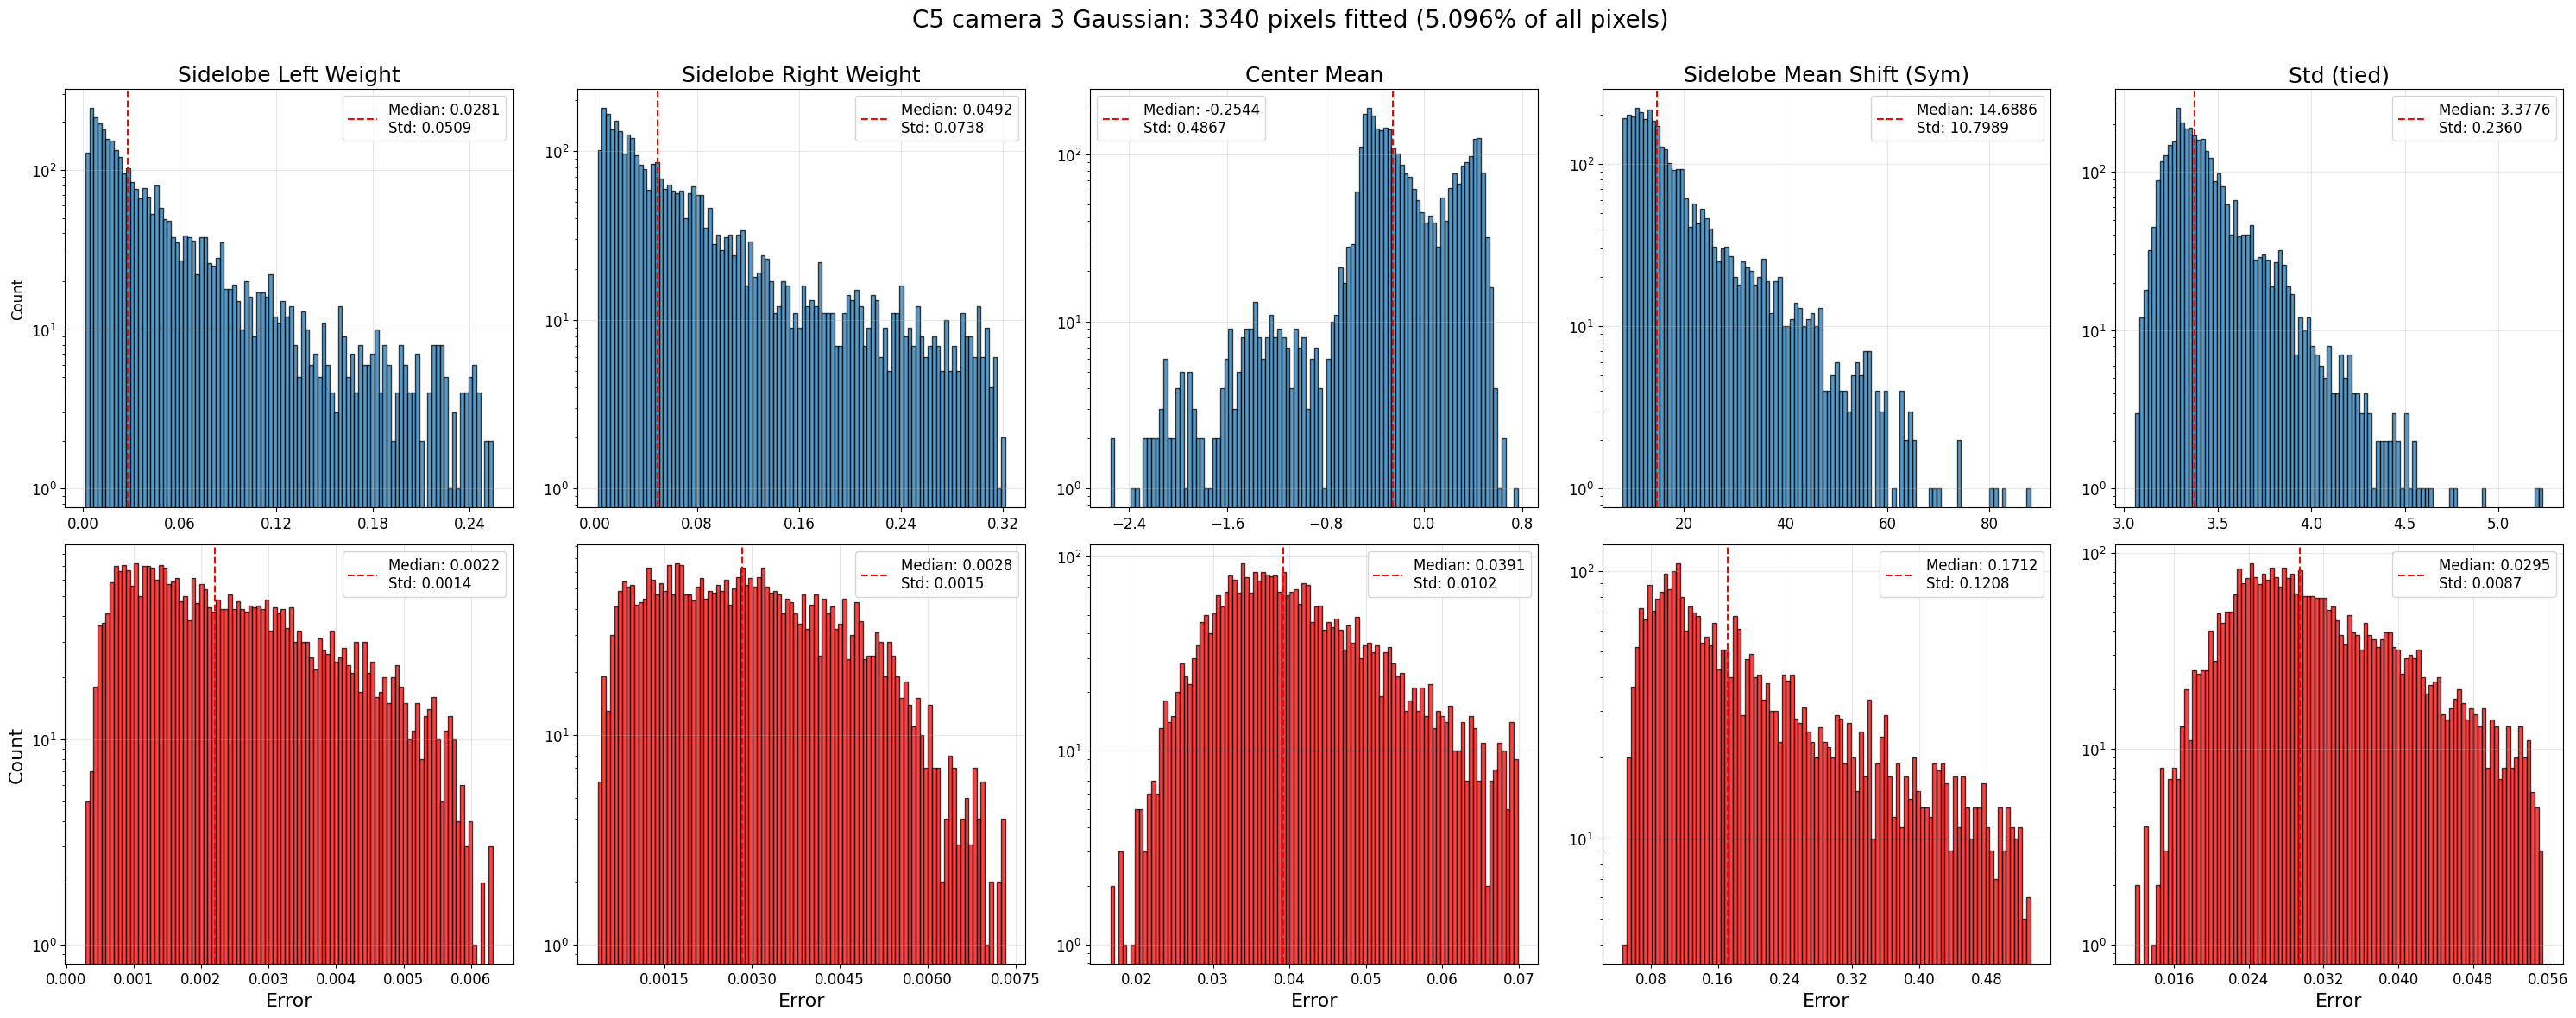

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


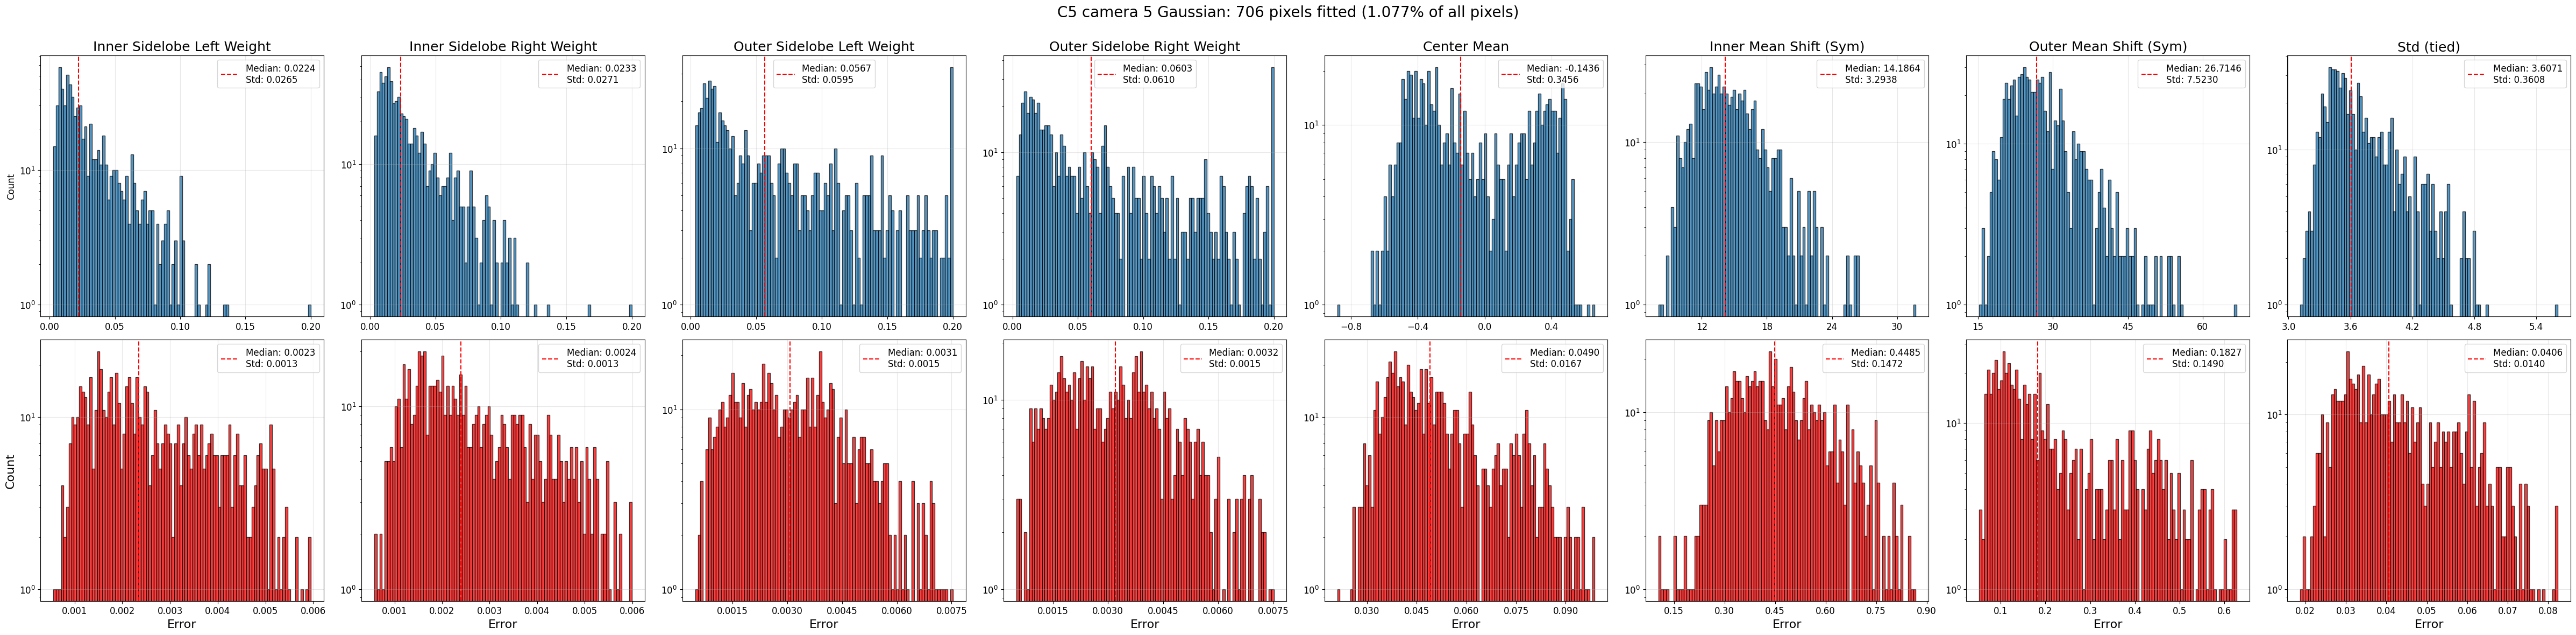

In [9]:
import matplotlib.ticker as ticker

# List of models to check.
models = ["1g", "2g_pos", "2g_neg", "3g", "5g"]

# Accumulate fitted parameters and their errors in nested dictionaries.
# For each model (or combined key), accum[model][i] holds all popt values for parameter i,
# and accum_err[model][i] holds all error values for parameter i.
accum = {}
accum_err = {}
for res in all_results:
    for m in models:
        if m == res["best_model"]:
            # For 2g models, combine under key "2g"
            key = "2g" if m in ["2g_pos", "2g_neg"] else m
            popt = res[m][0]
            perr = np.sqrt(np.diag(res[m][1]))
            # If model is 2g_neg, convert the second parameter (index 1) to negative.
            if m == "2g_neg":
                popt = list(popt)
                popt[1] = -popt[1]
            if key not in accum:
                n = len(popt)
                accum[key] = {i: [] for i in range(n)}
                accum_err[key] = {i: [] for i in range(n)}
            for i, val in enumerate(popt):
                accum[key][i].append(val)
            for i, err_val in enumerate(perr):
                accum_err[key][i].append(err_val)

# Compute total number of fitted pixels over all models.
fit_pixels = sum(len(accum[k][0]) for k in accum)
total_pixels = multip * multip  # assume multip is defined elsewhere

# Loop over each model in accum.
for m in accum:
    n_params = len(accum[m])
    
    # Create a figure with 2 rows and n_params columns.
    fig, axs = plt.subplots(2, n_params, figsize=(n_params * 6, 12))
    
    # If n_params is 1, ensure axs is 2D (array with shape (2,1))
    if n_params == 1:
        axs = np.array(axs).reshape(2, 1)
    
    # Define the model name string (mo) based on m.
    if m == "1g":
        mo = "1 Gaussian"
    elif m == "2g":
        mo = "2 Gaussian"
    elif m == "3g":
        mo = "3 Gaussian"
    elif m == "5g":
        mo = "5 Gaussian"
    
    # Get number of pixels fitted for current model.
    n_pixels = len(accum[m][0])
    if m == "1g":
        percentage = (n_pixels / fit_pixels * 100) if total_pixels > 0 else 0
        suptitle = f"C5 camera {mo}: {n_pixels} pixels fitted ({percentage:.3f}% of fitted pixels)\n"
    else:
        percentage = (n_pixels / total_pixels * 100) if total_pixels > 0 else 0
        suptitle = f"C5 camera {mo}: {n_pixels} pixels fitted ({percentage:.3f}% of all pixels)\n"
    
    # --- Top row: Plot parameter histograms ---
    # --- Top row: Plot parameter histograms ---
    for i in range(n_params):
        values = np.array(accum[m][i])
        median_val = np.median(values)
        std_val = np.std(values)
        axs[0, i].hist(values, bins=100, alpha=0.75, edgecolor='black')
        axs[0, i].axvline(median_val, color='red', linestyle='--',
                          label=f'Median: {median_val:.4f}\nStd: {std_val:.4f}')
        axs[0, i].set_yscale('log')
        
        # Define parameter name based on model and parameter index.
        if m == "1g":
            if i == 0:
                p = "Weight"
            elif i == 1:
                p = "Mean"
            elif i == 2:
                p = "Std"
        elif m == "2g":
            if i == 0:
                p = "Center Weight"
            elif i == 1:
                p = "Center Mean"
            elif i == 2:
                p = "Mean Shift"
            elif i == 3:
                p = "Std"
        elif m == "3g":
            if i == 0:
                p = "Sidelobe Left Weight"
            elif i == 1:
                p = "Sidelobe Right Weight"
            elif i == 2:
                p = "Center Mean"
            elif i == 3:
                p = "Sidelobe Mean Shift (Sym)"
            elif i == 4:
                p = "Std (tied)"
        elif m == "5g":
            if i == 0:
                p = "Inner Sidelobe Left Weight"
            elif i == 1:
                p = "Inner Sidelobe Right Weight"
            elif i == 2:
                p = "Outer Sidelobe Left Weight"
            elif i == 3:
                p = "Outer Sidelobe Right Weight"
            elif i == 4:
                p = "Center Mean"
            elif i == 5:
                p = "Inner Mean Shift (Sym)"
            elif i == 6:
                p = "Outer Mean Shift (Sym)"
            elif i == 7:
                p = "Std (tied)"
        
        axs[0, i].set_title(f'{p}', fontsize=18)
        if i == 0:
            axs[0, i].set_ylabel("Count", fontsize=12)
        axs[0, i].grid(alpha=0.3)
        axs[0, i].tick_params(axis='both', which='major', labelsize=12)
        axs[0, i].legend(fontsize=12)
        
        # Limit the number of major ticks on the x-axis to about 5
        axs[0, i].xaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # --- Bottom row: Plot error histograms ---
    for i in range(n_params):
        err_values = np.array(accum_err[m][i])
        median_err = np.median(err_values)
        std_err = np.std(err_values)
        axs[1, i].hist(err_values, bins=100, alpha=0.75, edgecolor='black', color='red')
        axs[1, i].axvline(median_err, color='red', linestyle='--',
                          label=f'Median: {median_err:.4f}\nStd: {std_err:.4f}')
        axs[1, i].set_yscale('log')
        axs[1, i].set_xlabel("Error", fontsize=16)
        if i == 0:
            axs[1, i].set_ylabel("Count", fontsize=16)
        axs[1, i].grid(alpha=0.3)
        axs[1, i].tick_params(axis='both', which='major', labelsize=12)
        axs[1, i].legend(fontsize=12)
        
        # Limit the number of major ticks on the x-axis to about 5
        axs[1, i].xaxis.set_major_locator(ticker.MaxNLocator(7))
        
    fig.suptitle(suptitle, fontsize=20)
    
    plt.tight_layout()
    # Save the plot as PNG and EPS with high resolution.
    plt.savefig(f"plots/c5_hist_model_{m}.png", format="png", dpi=600, bbox_inches='tight')
    plt.savefig(f"plots/c5_hist_model_{m}.eps", format="eps", bbox_inches='tight')
    plt.show()
